In [1]:
%run supportvectors-common.ipynb



<div style="color:#aaa;font-size:8pt">
<hr/>

 </blockquote>
 <hr/>
</div>



# Dataset `classifier-3`

Let us start our study of classifiers with a simple dataset. we will attempt to model it with logistic regression classifier and linear discriminant analysis.

**GOAL**
* Understand the appropriate workflow for classification tasks
* Understand the workings of the logistic regression classifier
* Also, understand the working of linear discriminant analysis

## Exploratory data analysis

We will follow our well-trodden path of systematically load the data, explore and visualize it.

### Load data and observe its statistics

In [2]:
data = pd.read_csv ("https://raw.githubusercontent.com/supportvectors/ml-100/master/classifier-3.csv")
data = data.dropna()
data.describe(include='all').transpose()

count      mean       std        min       25%       50%       75%  \
x1  2000.0  0.572446  4.020438 -13.962782 -2.199305  0.702220  3.181777   
x2  2000.0  0.527342  3.954696 -14.261571 -2.136168  0.536767  3.164408   
t   2000.0  0.368500  0.482519   0.000000  0.000000  0.000000  1.000000   

          max  
x1  13.999959  
x2  15.570375  
t    1.000000

In [3]:
#data.t = data.t.astype('category')

### Visualizations

Let us now plot the data, and observe some of its key qualities.

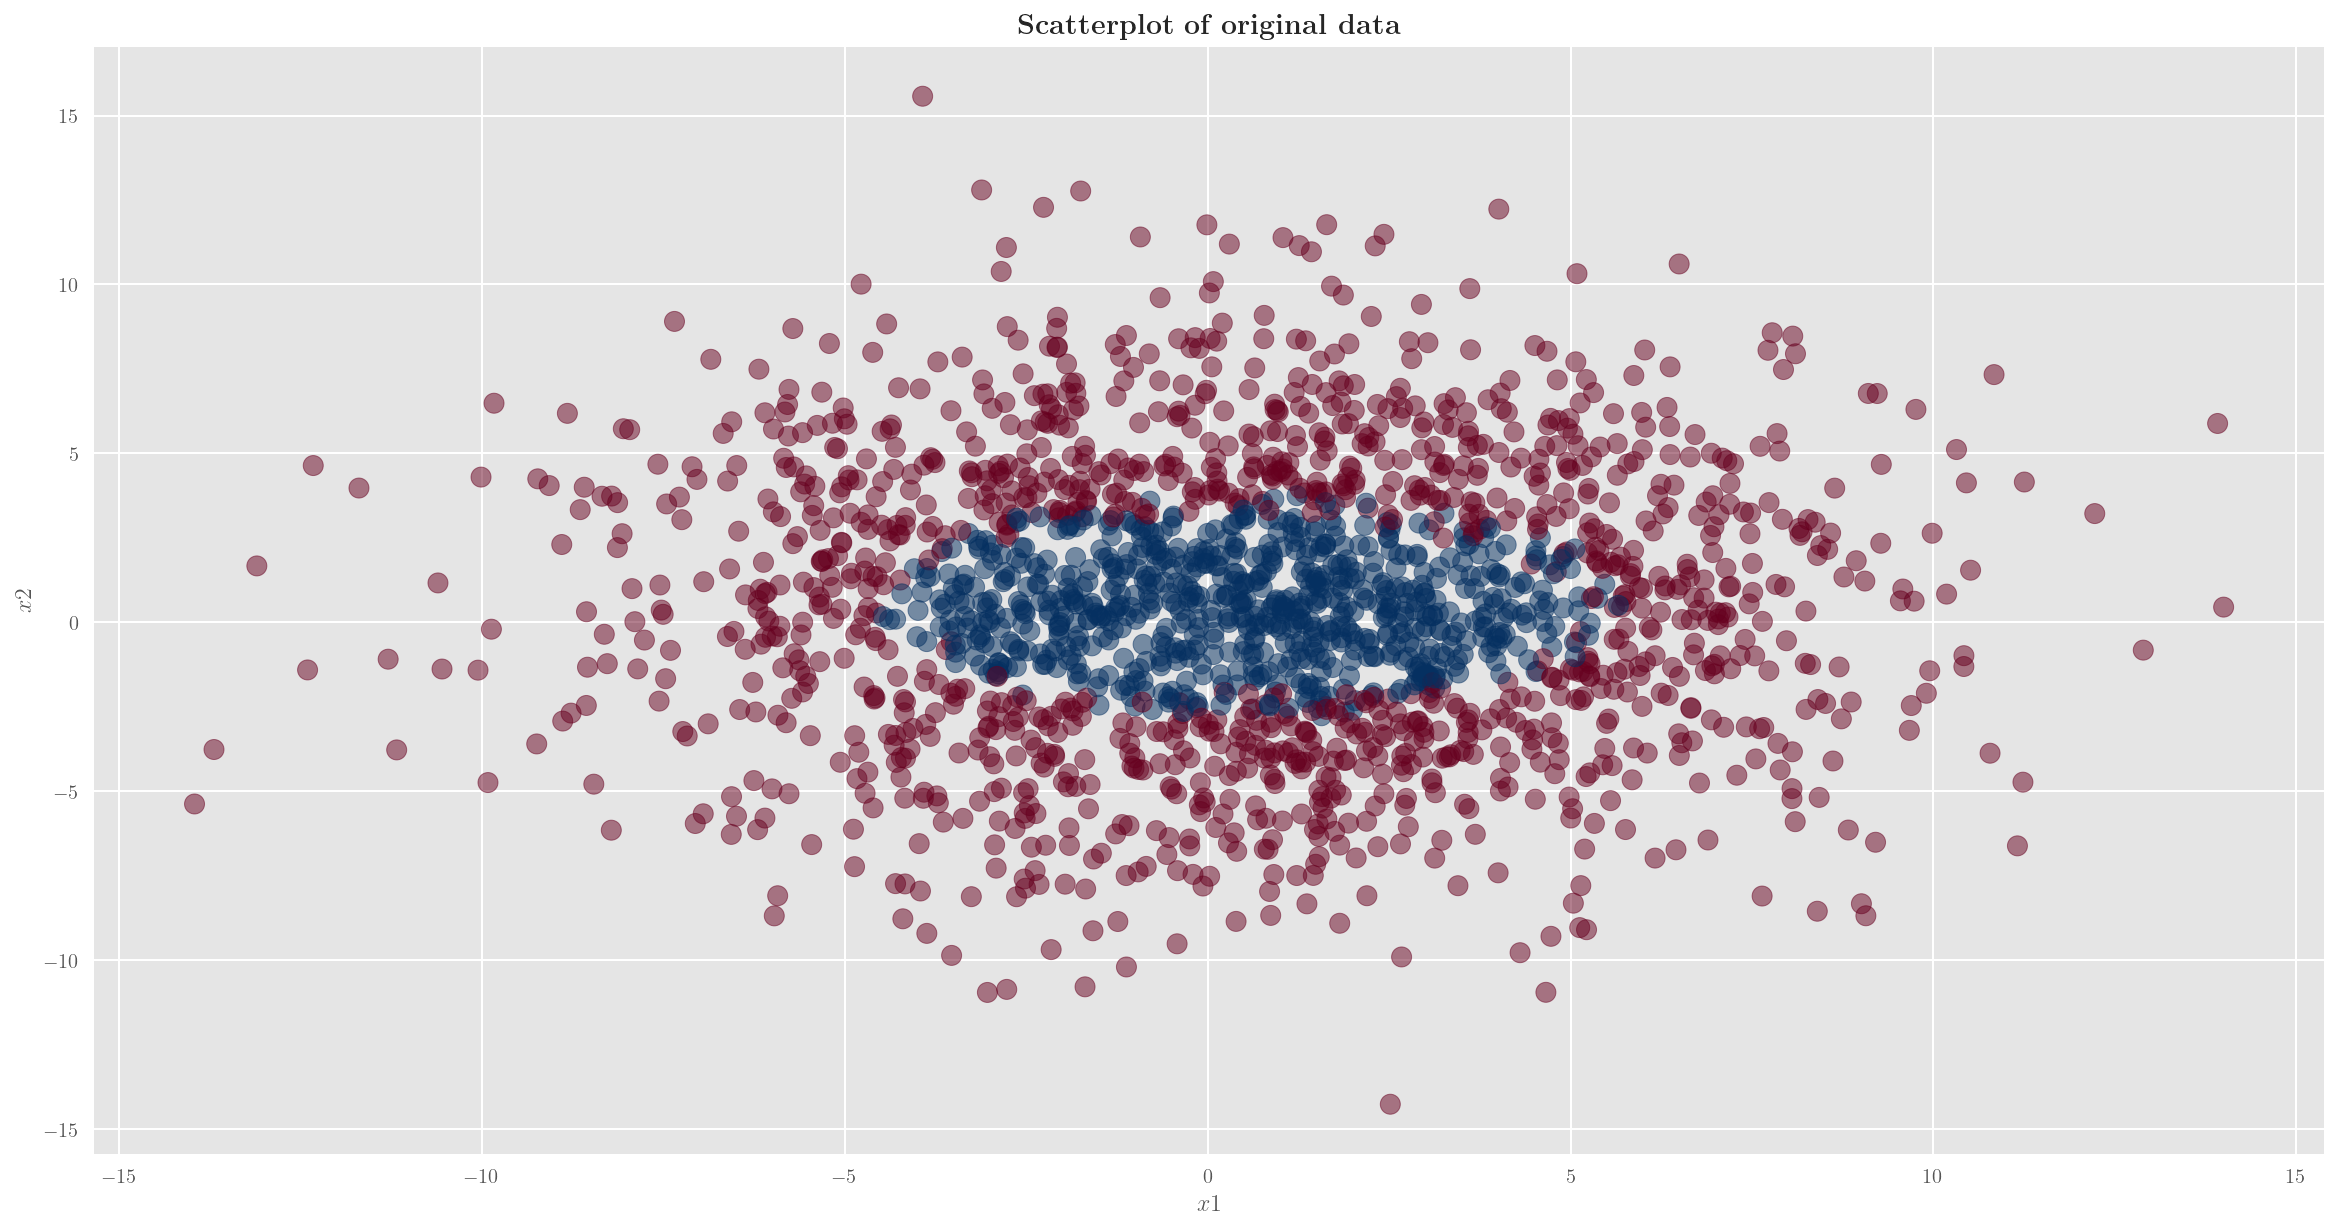

In [4]:
plt.scatter(data['x1'],   # as the x-axis 
            data['x2'],   # as the y-axis
            s=100,
            alpha=0.5, # size
            c=data['t'],
             cmap="RdBu")
plt.xlabel (r"$x1$")
plt.ylabel(r"$x2$")
plt.title(r'\textbf{Scatterplot of original data}')
plt.show ()

The scatterplot above leads us to believe that one may reasonably consider a linear decision boundary, and thus a linear classifier to model this data.

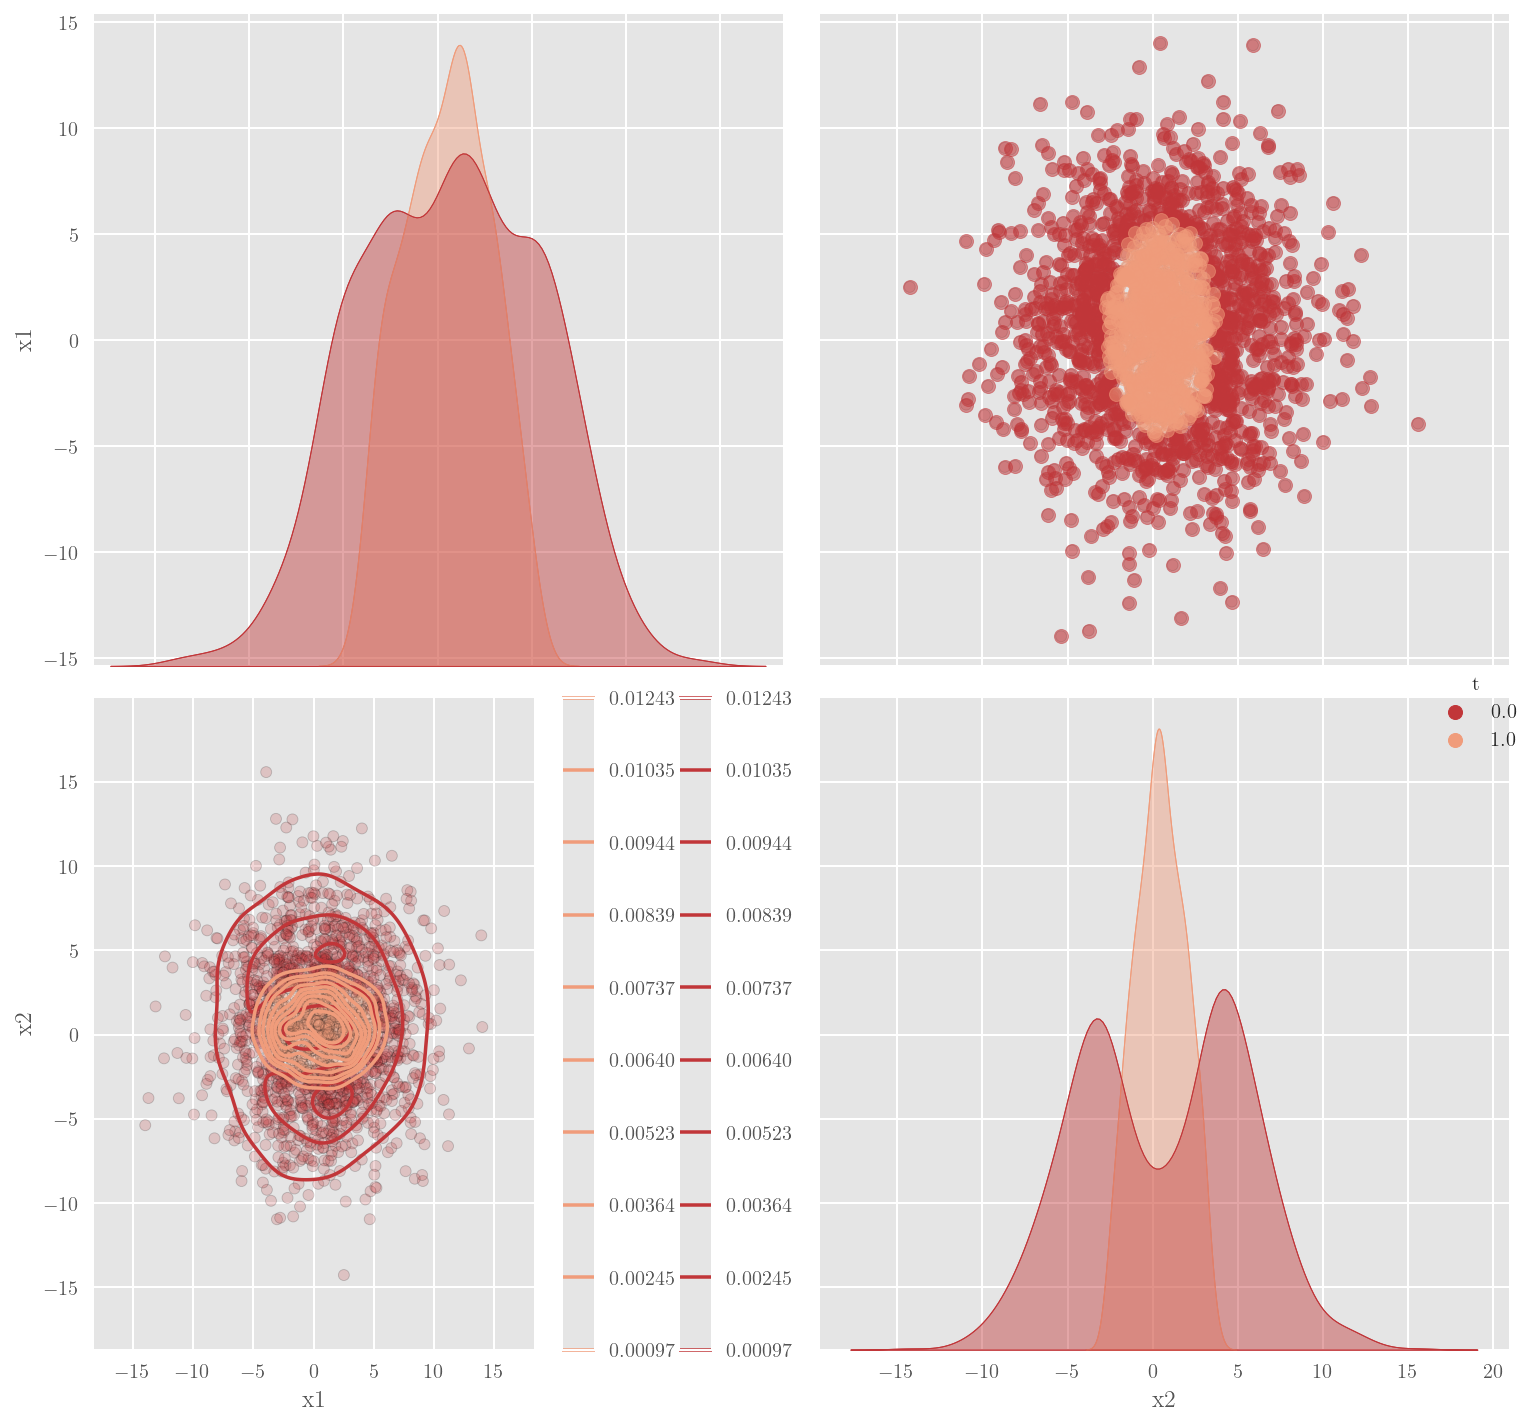

In [5]:
sns.set_palette("RdBu")

sample = data
g = sns.pairplot(sample, diag_kind='kde', 
                   plot_kws = { 'alpha': 0.20, 's': 30, 'edgecolor': 'k',  }, 
                   size=5, hue='t');
g.map_diag(sns.kdeplot,shade=True);
g.map_upper(plt.scatter,   alpha=0.5);
g.map_lower(sns.kdeplot, shade=False, shade_lowest=False, cbar=True);

plt.tight_layout()

Separate out the predictors from the response, and split the data into the training and test subsets.

In [6]:
X, y = data[['x1', 'x2']], data['t']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Logistic Regression Classifier

Let us now attempt to model this data with a logistic regression classifier,on the hypothesis that it may be a linear dataset.

In [7]:
classifier = LogisticRegression(solver='newton-cg')
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

### Model diagnostics

In [8]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)

[[319   0]
 [181   0]]


In [9]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78       319
         1.0       0.00      0.00      0.00       181

    accuracy                           0.64       500
   macro avg       0.32      0.50      0.39       500
weighted avg       0.41      0.64      0.50       500



In [10]:
print("{:15}: {} ".format('Classes',classifier.classes_))
print('{:15}: {} '.format('Coefficients',classifier.coef_))
print('{:15}: {} '.format('Intercept', classifier.intercept_))


Classes        : [0. 1.] 
Coefficients   : [[-0.00436906 -0.01887268]] 
Intercept      : [-0.51612493] 


### Class Probabilities

In the `sklearn` library, the class probabilities can be seen using the `.predict_proba(X)` method. It returns an array whose rows are the predictions for each row of `X`, and the columns are the class probabilities. In the clase of binary classifier, it is enough to retrieve the proabilities of one of the classes, since the other will be the complement of it.

In [11]:
predictions = classifier.predict_proba(X)[:, 1].reshape(y.shape)
predictions

array([0.36551959, 0.35285348, 0.35878009, ..., 0.35838877, 0.38929054,
       0.35813535])

The `yellowbrick` library provides a succient visualization of the model metrics.

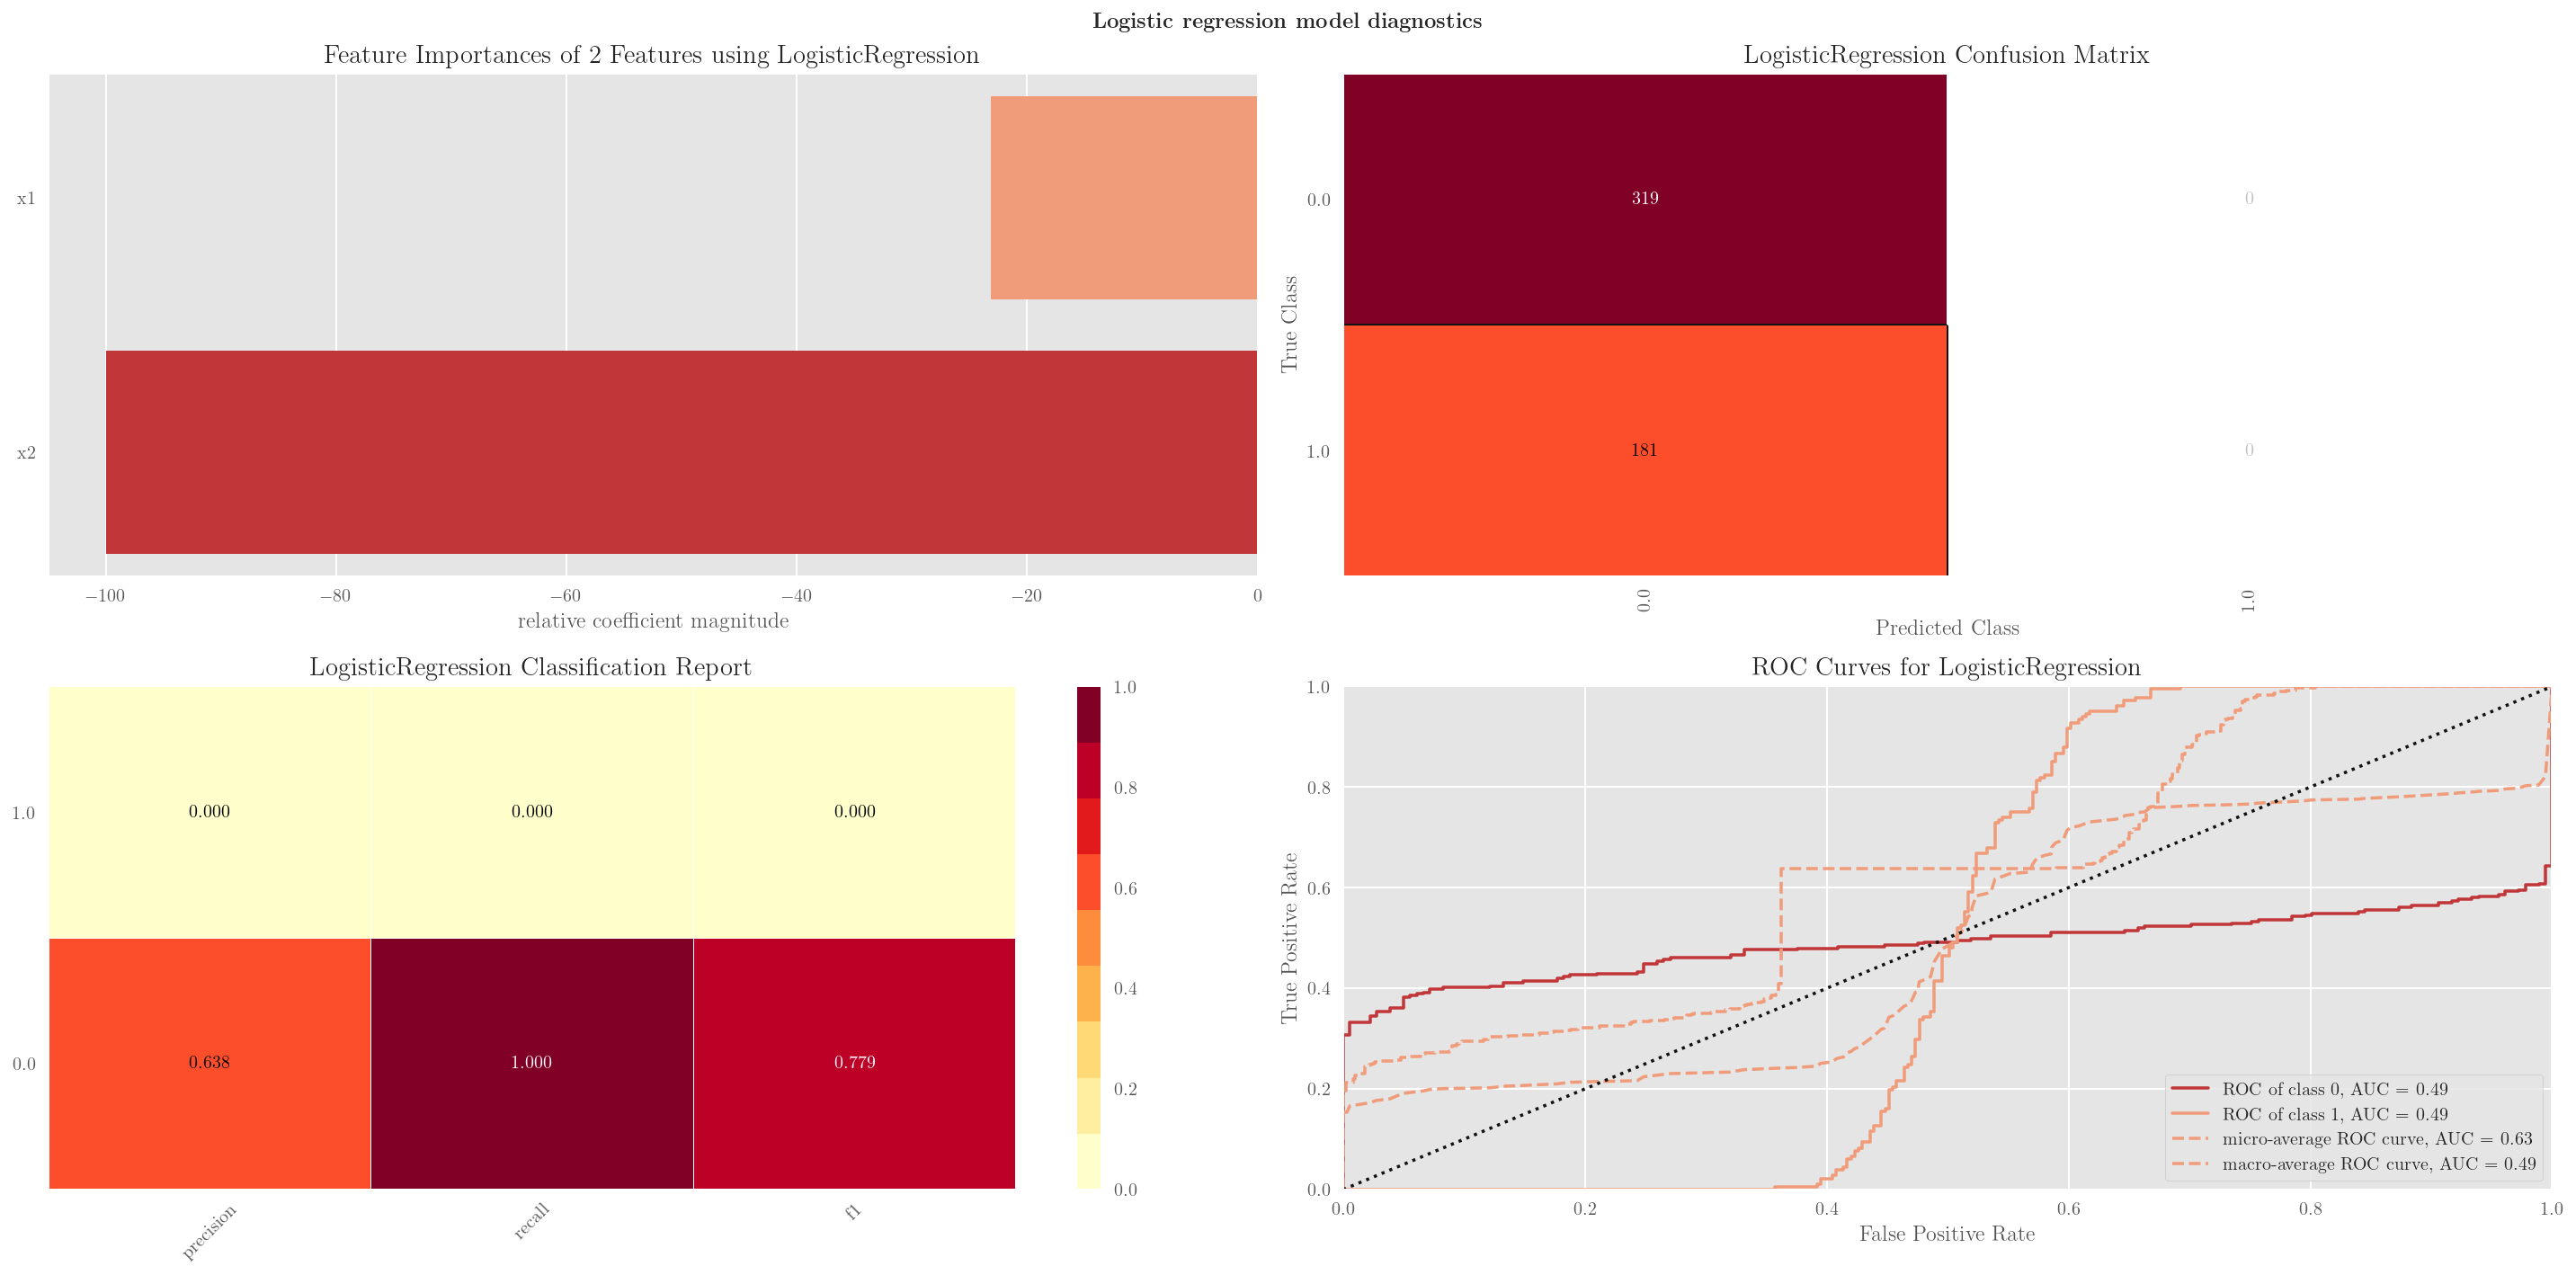

In [12]:

fig, axes = plt.subplots(2, 2)

model = classifier
visualgrid = [
    FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test, )
    viz.finalize()

plt.suptitle(r'\textbf{Logistic regression model diagnostics}');
plt.tight_layout();

The model diagnostics appear to be encouraging. Let us now visualize the model's predictions, and its decision boundary that splits the feature space.

### Visual model predictions

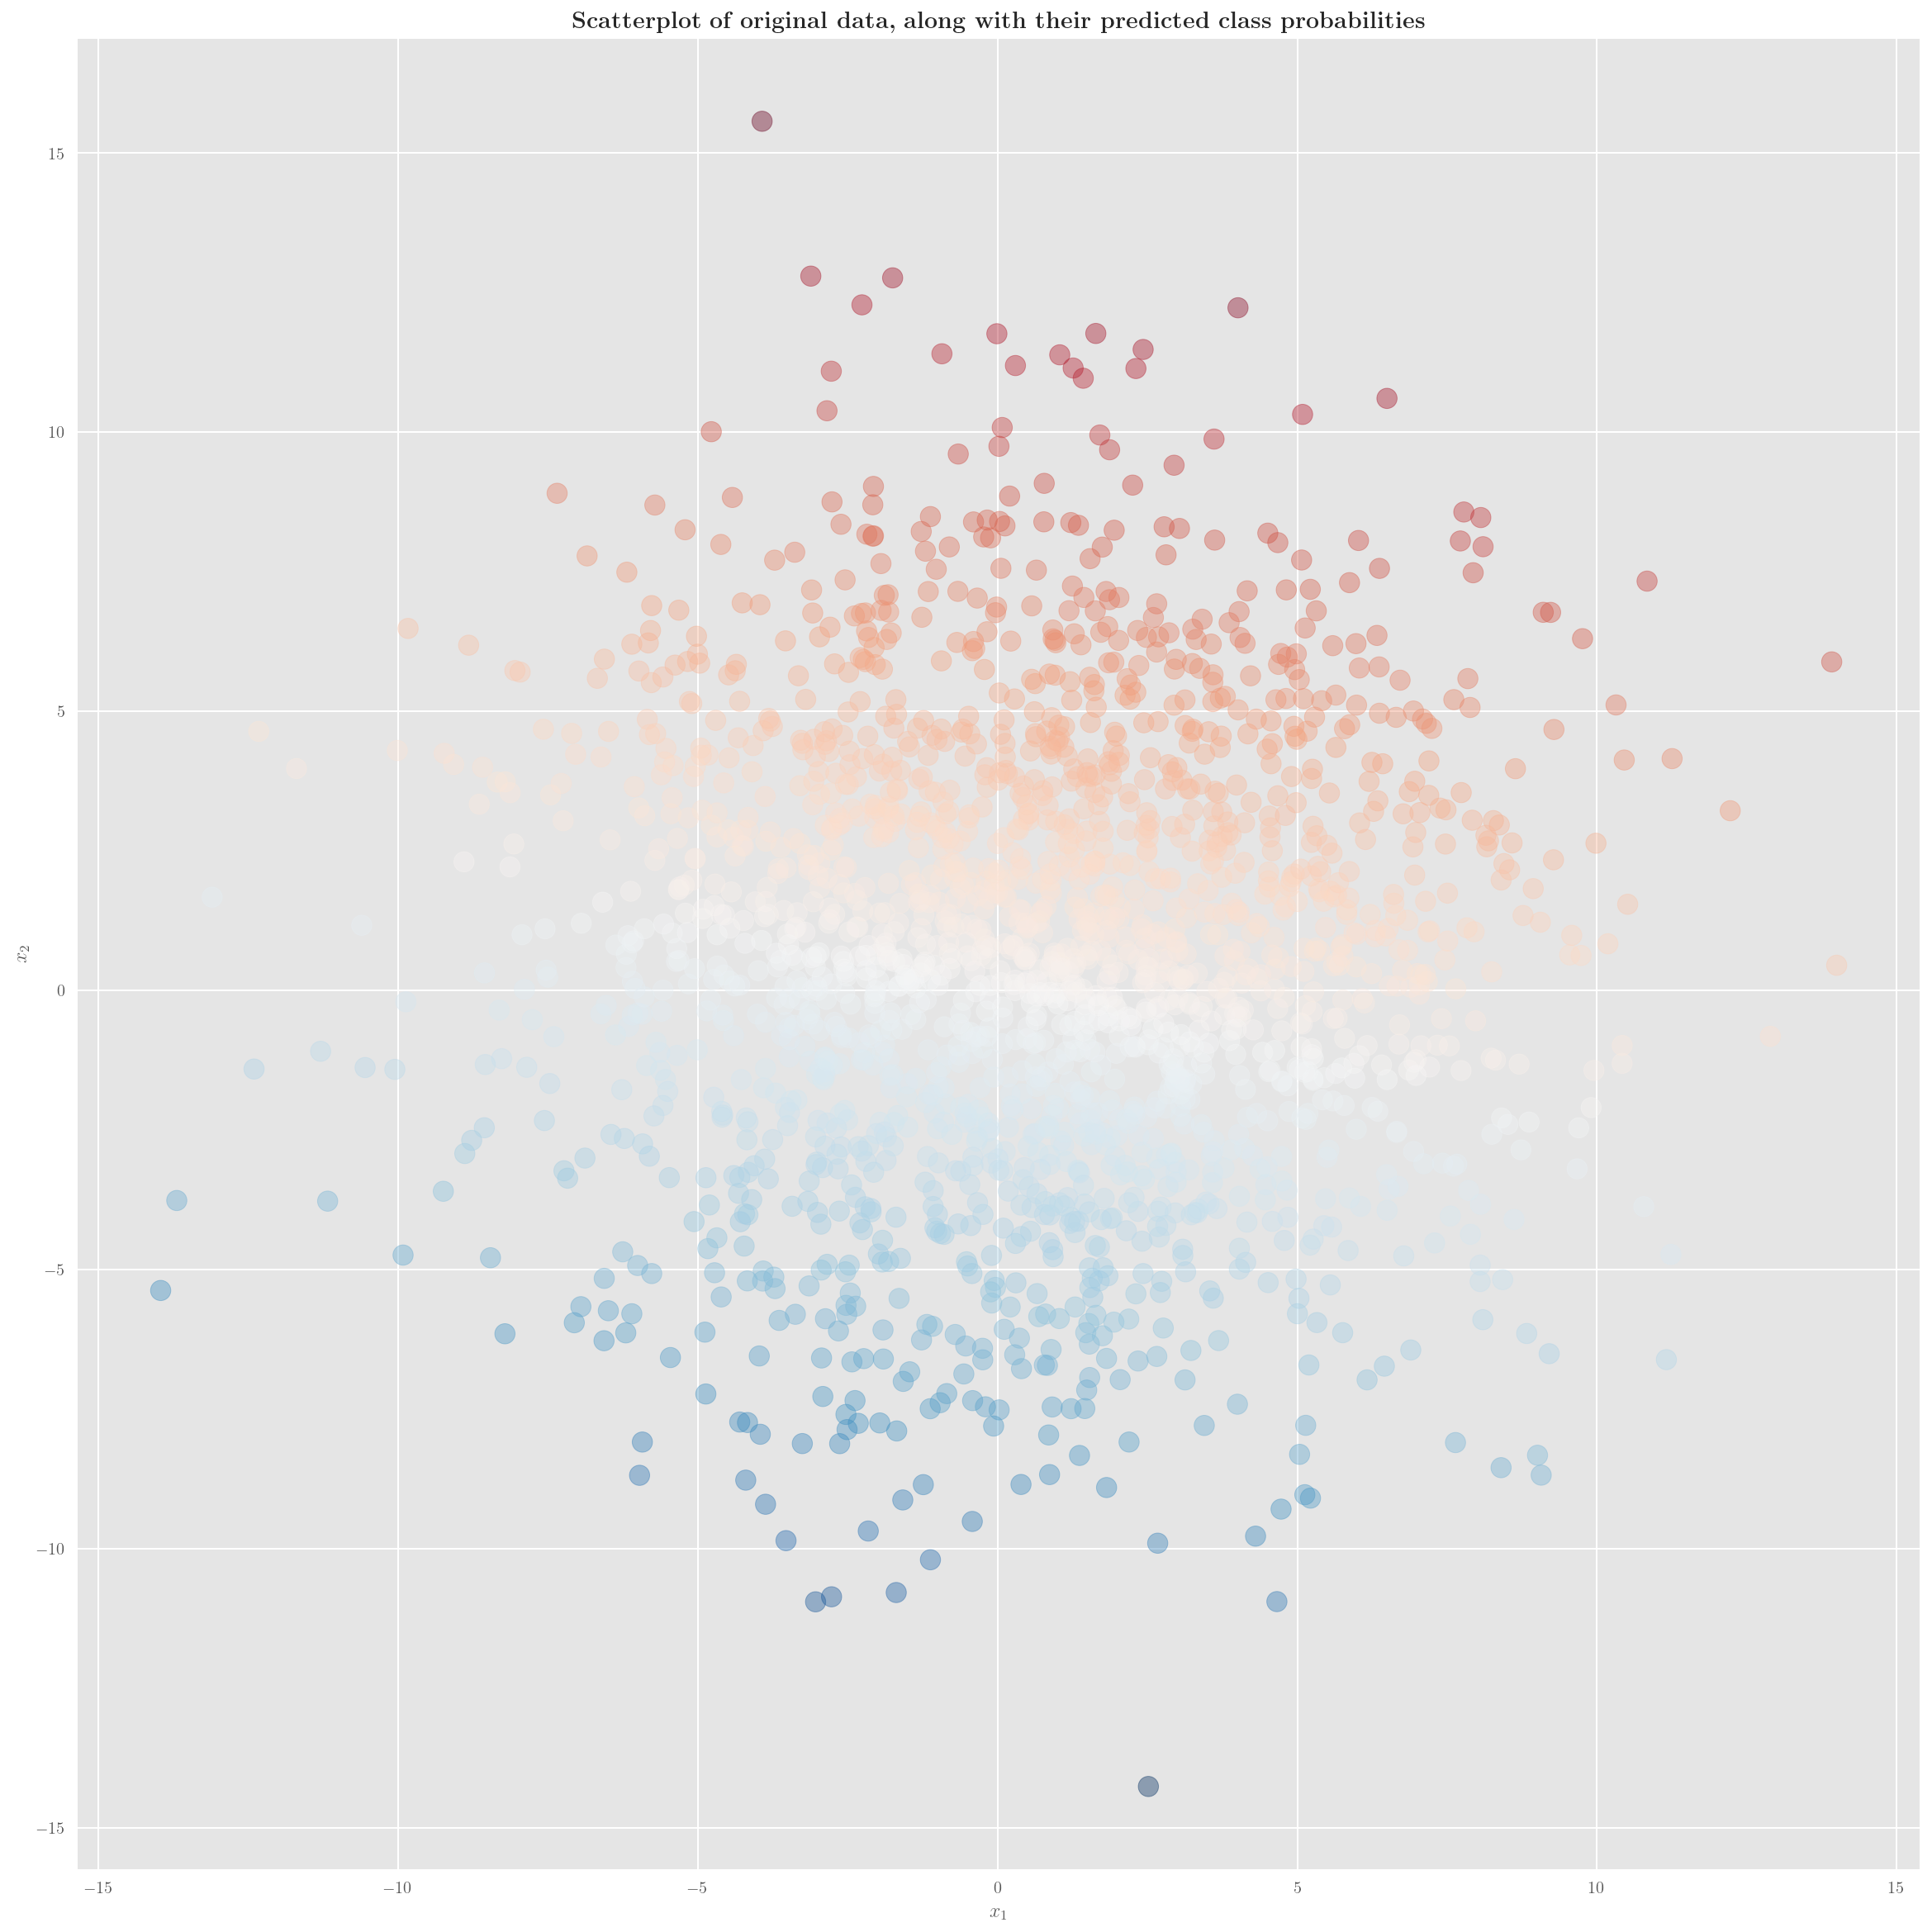

In [13]:
plt.figure(figsize=(20,20))
plt.scatter(X['x1'],   # as the x-axis 
            X['x2'],   # as the y-axis
            s=150,
            alpha=0.4, # size
            c=predictions,
            cmap='RdBu',
            
           )
plt.xlabel (r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r'\textbf{Scatterplot of original data, along with their predicted class probabilities}');


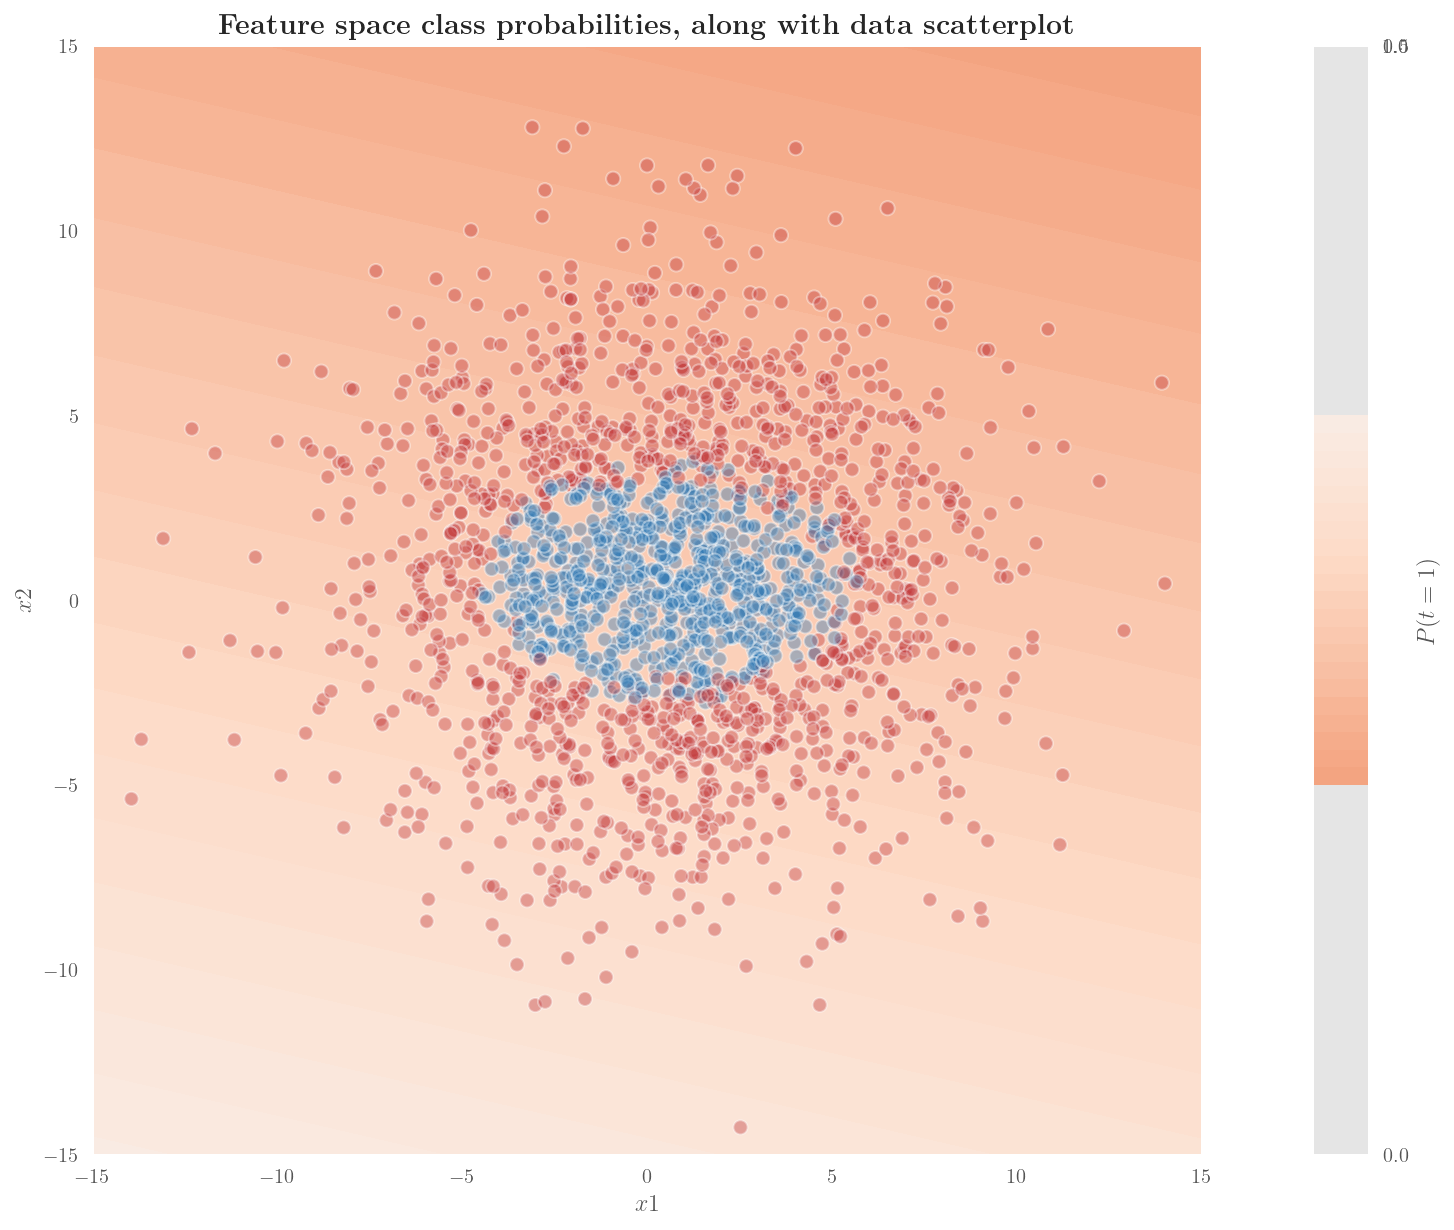

In [14]:

sample_x, sample_y = np.mgrid[-15:15:.01, -15:15:.01]
grid = np.c_[sample_x.ravel(), sample_y.ravel()]

probs = classifier.predict_proba(grid)[:, 1].reshape(sample_x.shape)

# Now let us draw the decision-boundary
figure, axes = plt.subplots(figsize=(20,10));
contour = axes.contourf (sample_x, 
                         sample_y, 
                         probs, 
                         25, 
                         cmap="RdBu",
                         vmin=0,
                         vmax=1);
axes_color = figure.colorbar(contour)
axes_color.set_label("$P(t=1)$")
axes_color.set_ticks ([0.0, 0.5, 1.0])


# Draw the scatterplot
axes.scatter(X['x1'], 
             X['x2'], 
             c=y, 
             s=50, 
             cmap="RdBu", 
             vmin=-0.2, 
             vmax=1.2, 
             edgecolor="white", 
             linewidth=1,
             alpha=0.4);

#Labels, etc.
axes.set(aspect="equal", 
         xlim=(-15,15),
         ylim=(-15,15),
         xlabel=r'$x1$',
         ylabel=r'$x2$'
        );

plt.title(r'\textbf{Feature space class probabilities, along with data scatterplot}');



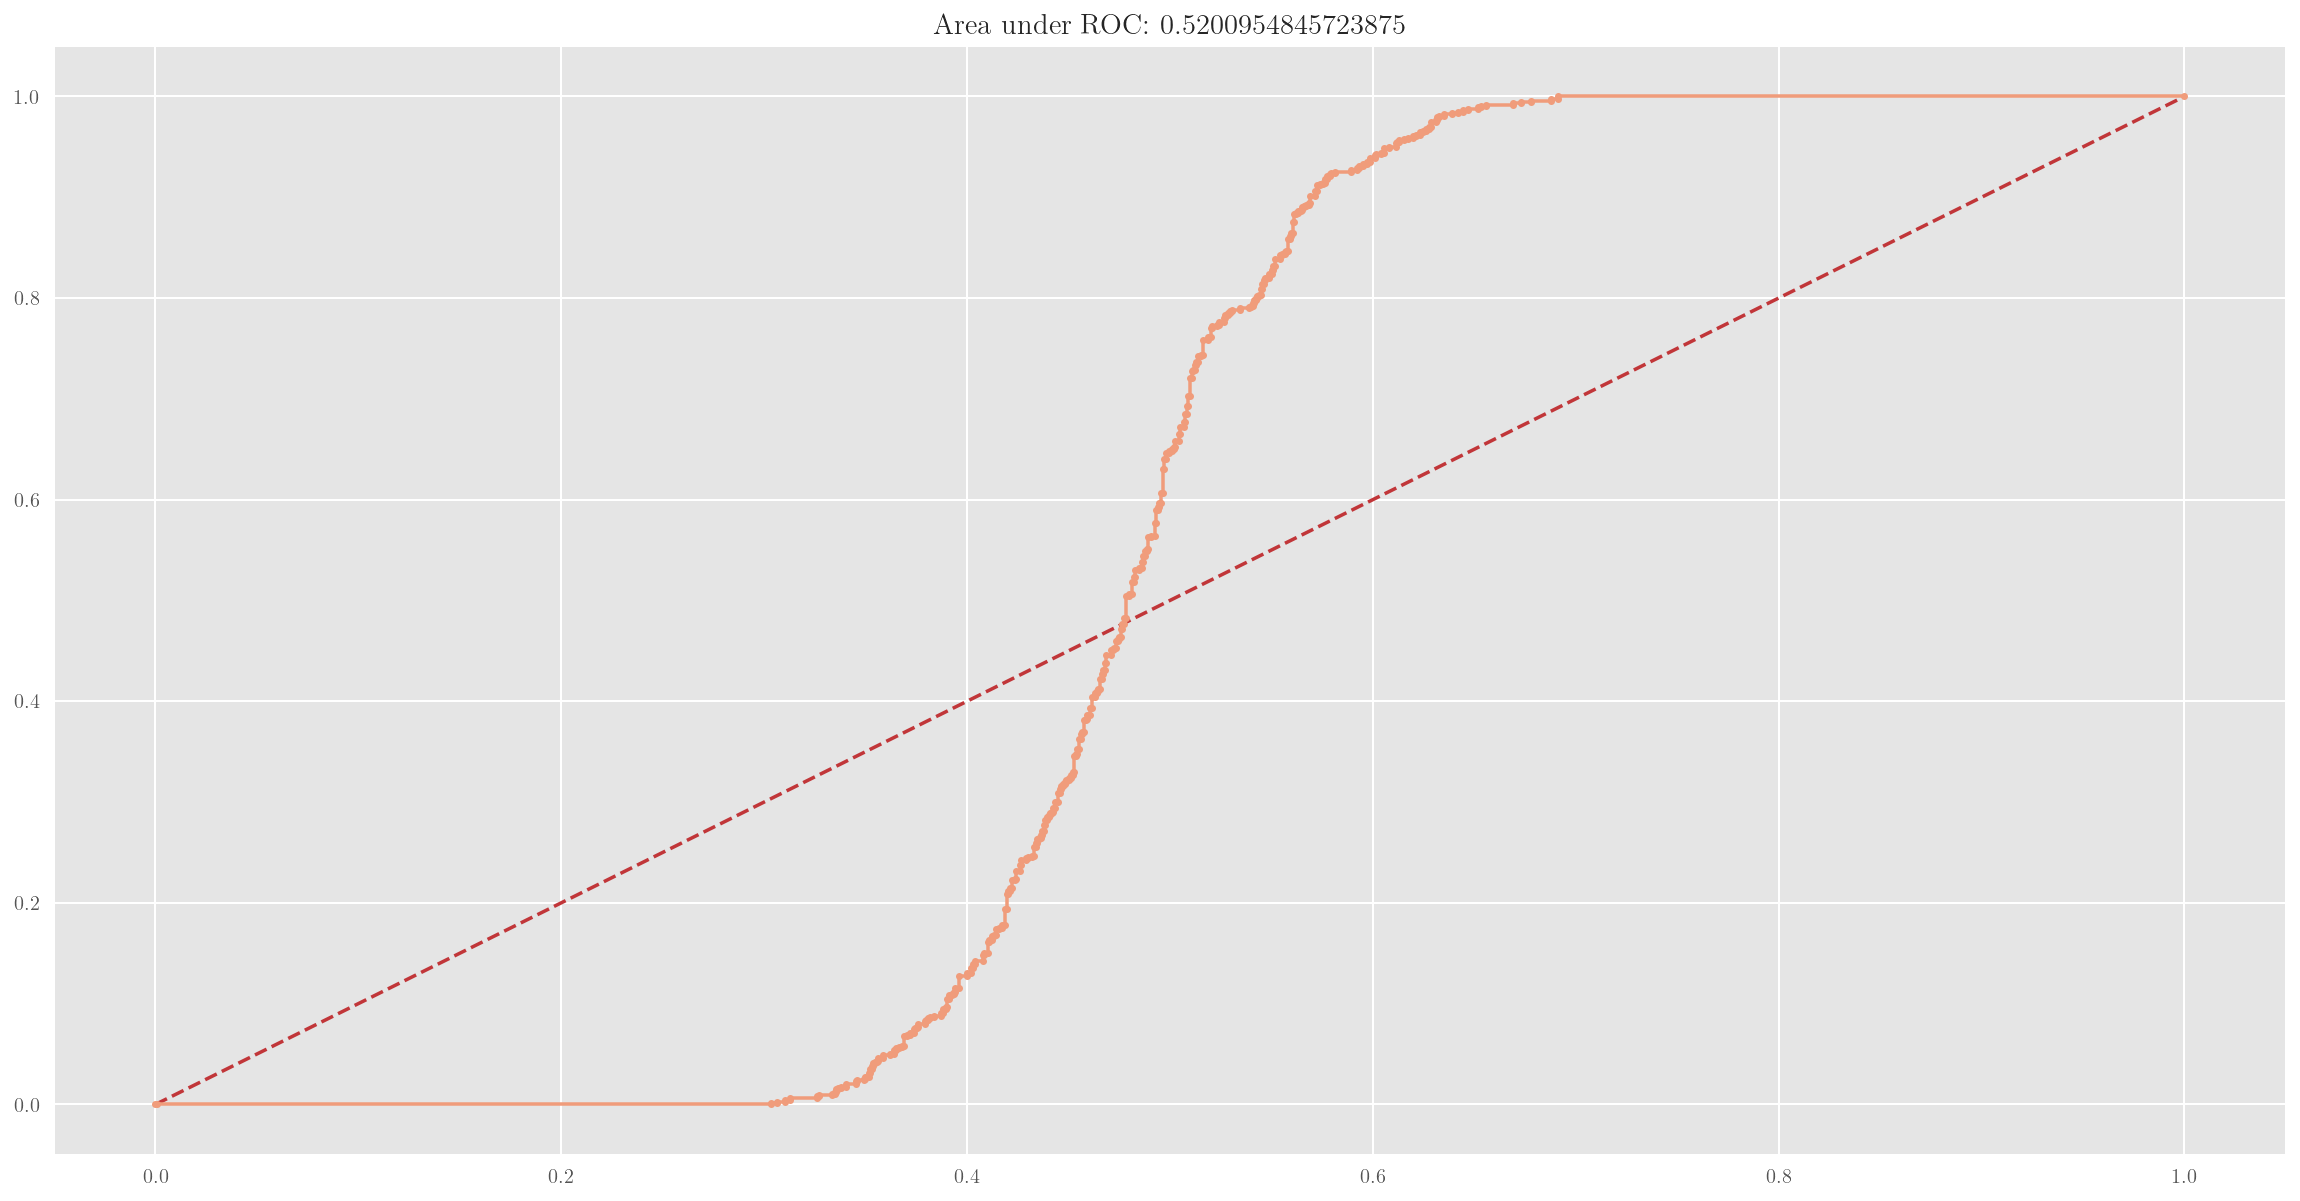

In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y, predictions)
auROC = roc_auc_score(y, predictions)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.title("Area under ROC: {}".format(auROC))
plt.show()

#### Simply drawing the decision-boundary over the points

In [16]:
# In the notation of our text-book:
#
xx    = np.arange(-15,15, 0.1)
beta0 = classifier.intercept_
beta1 = classifier.coef_[0][0]
beta2 = classifier.coef_[0][1]
#
# Decision-Boundary: beta0 + beta1*x + beta2*y = 0
#
line_intercept = -beta0/beta2
line_slope     = -beta1/beta2
print ("intercept: %s, slope %s" % (line_intercept, line_slope))

#
# Equation of line, on
#
yy = line_intercept + line_slope*xx

intercept: [-27.34772427], slope -0.23150169261403394


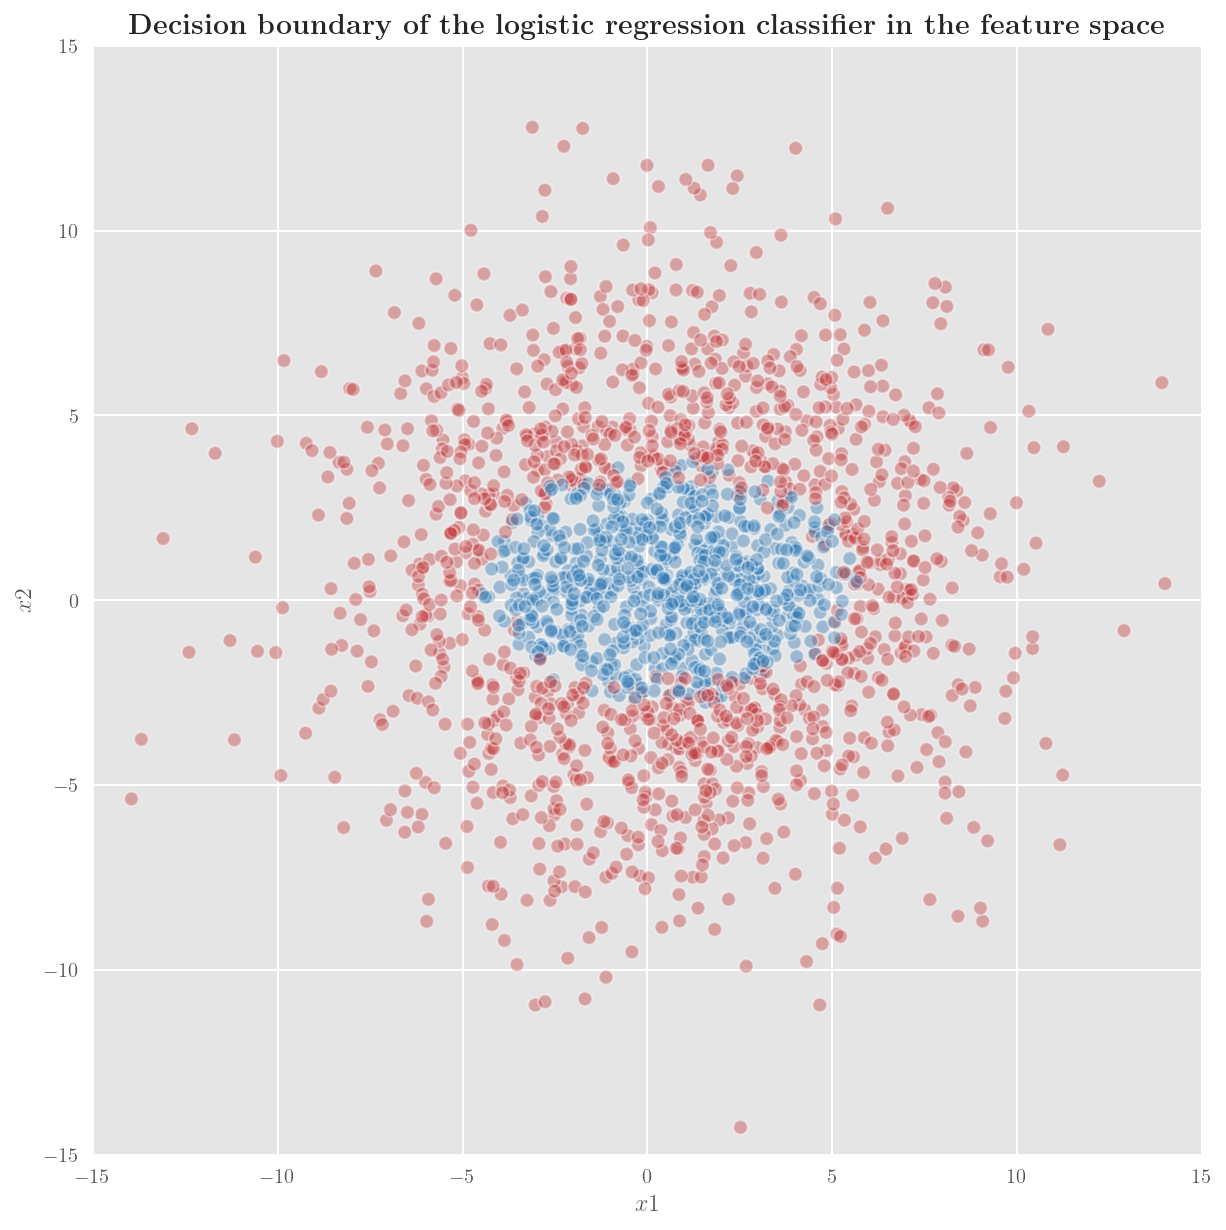

In [17]:
figure, axes = plt.subplots(figsize=(20,10))


# Draw the scatterplot
axes.scatter(data.x1, 
             data.x2, 
             c=data.t, 
             s=50, 
             cmap="RdBu", 
             vmin=-0.2, 
             vmax=1.2, 
             edgecolor="white", 
             linewidth=1,
             alpha=0.4);

axes.plot(xx, yy, lw=3, color="maroon");
axes.annotate('Decision Boundary', 
              xy=(xx[50], yy[50]),
              xytext=(-5, 14),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=14,
             fontweight='bold',);

#Labels, etc.
axes.set(aspect="equal", 
         xlim=(-15,15),
         ylim=(-15,15),
         xlabel="$x1$",
         ylabel="$x2$"
        );
axes.set_title(r'\textbf{Decision boundary of the logistic regression classifier in the feature space}');


# Linear Discriminant Analysis

In [18]:
lda = QuadraticDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

### Model diagnostics

In [19]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)

[[319   0]
 [ 35 146]]


In [20]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       319
         1.0       1.00      0.81      0.89       181

    accuracy                           0.93       500
   macro avg       0.95      0.90      0.92       500
weighted avg       0.94      0.93      0.93       500



### Class Probabilities

In the `sklearn` library, the class probabilities can be seen using the `.predict_proba(X)` method. It returns an array whose rows are the predictions for each row of `X`, and the columns are the class probabilities. In the clase of binary classifier, it is enough to retrieve the proabilities of one of the classes, since the other will be the complement of it.

In [21]:
predictions = lda.predict_proba(X)[:, 1].reshape(y.shape)
yhat=lda.predict(X)

The `yellowbrick` library provides a succient visualization of the model metrics.

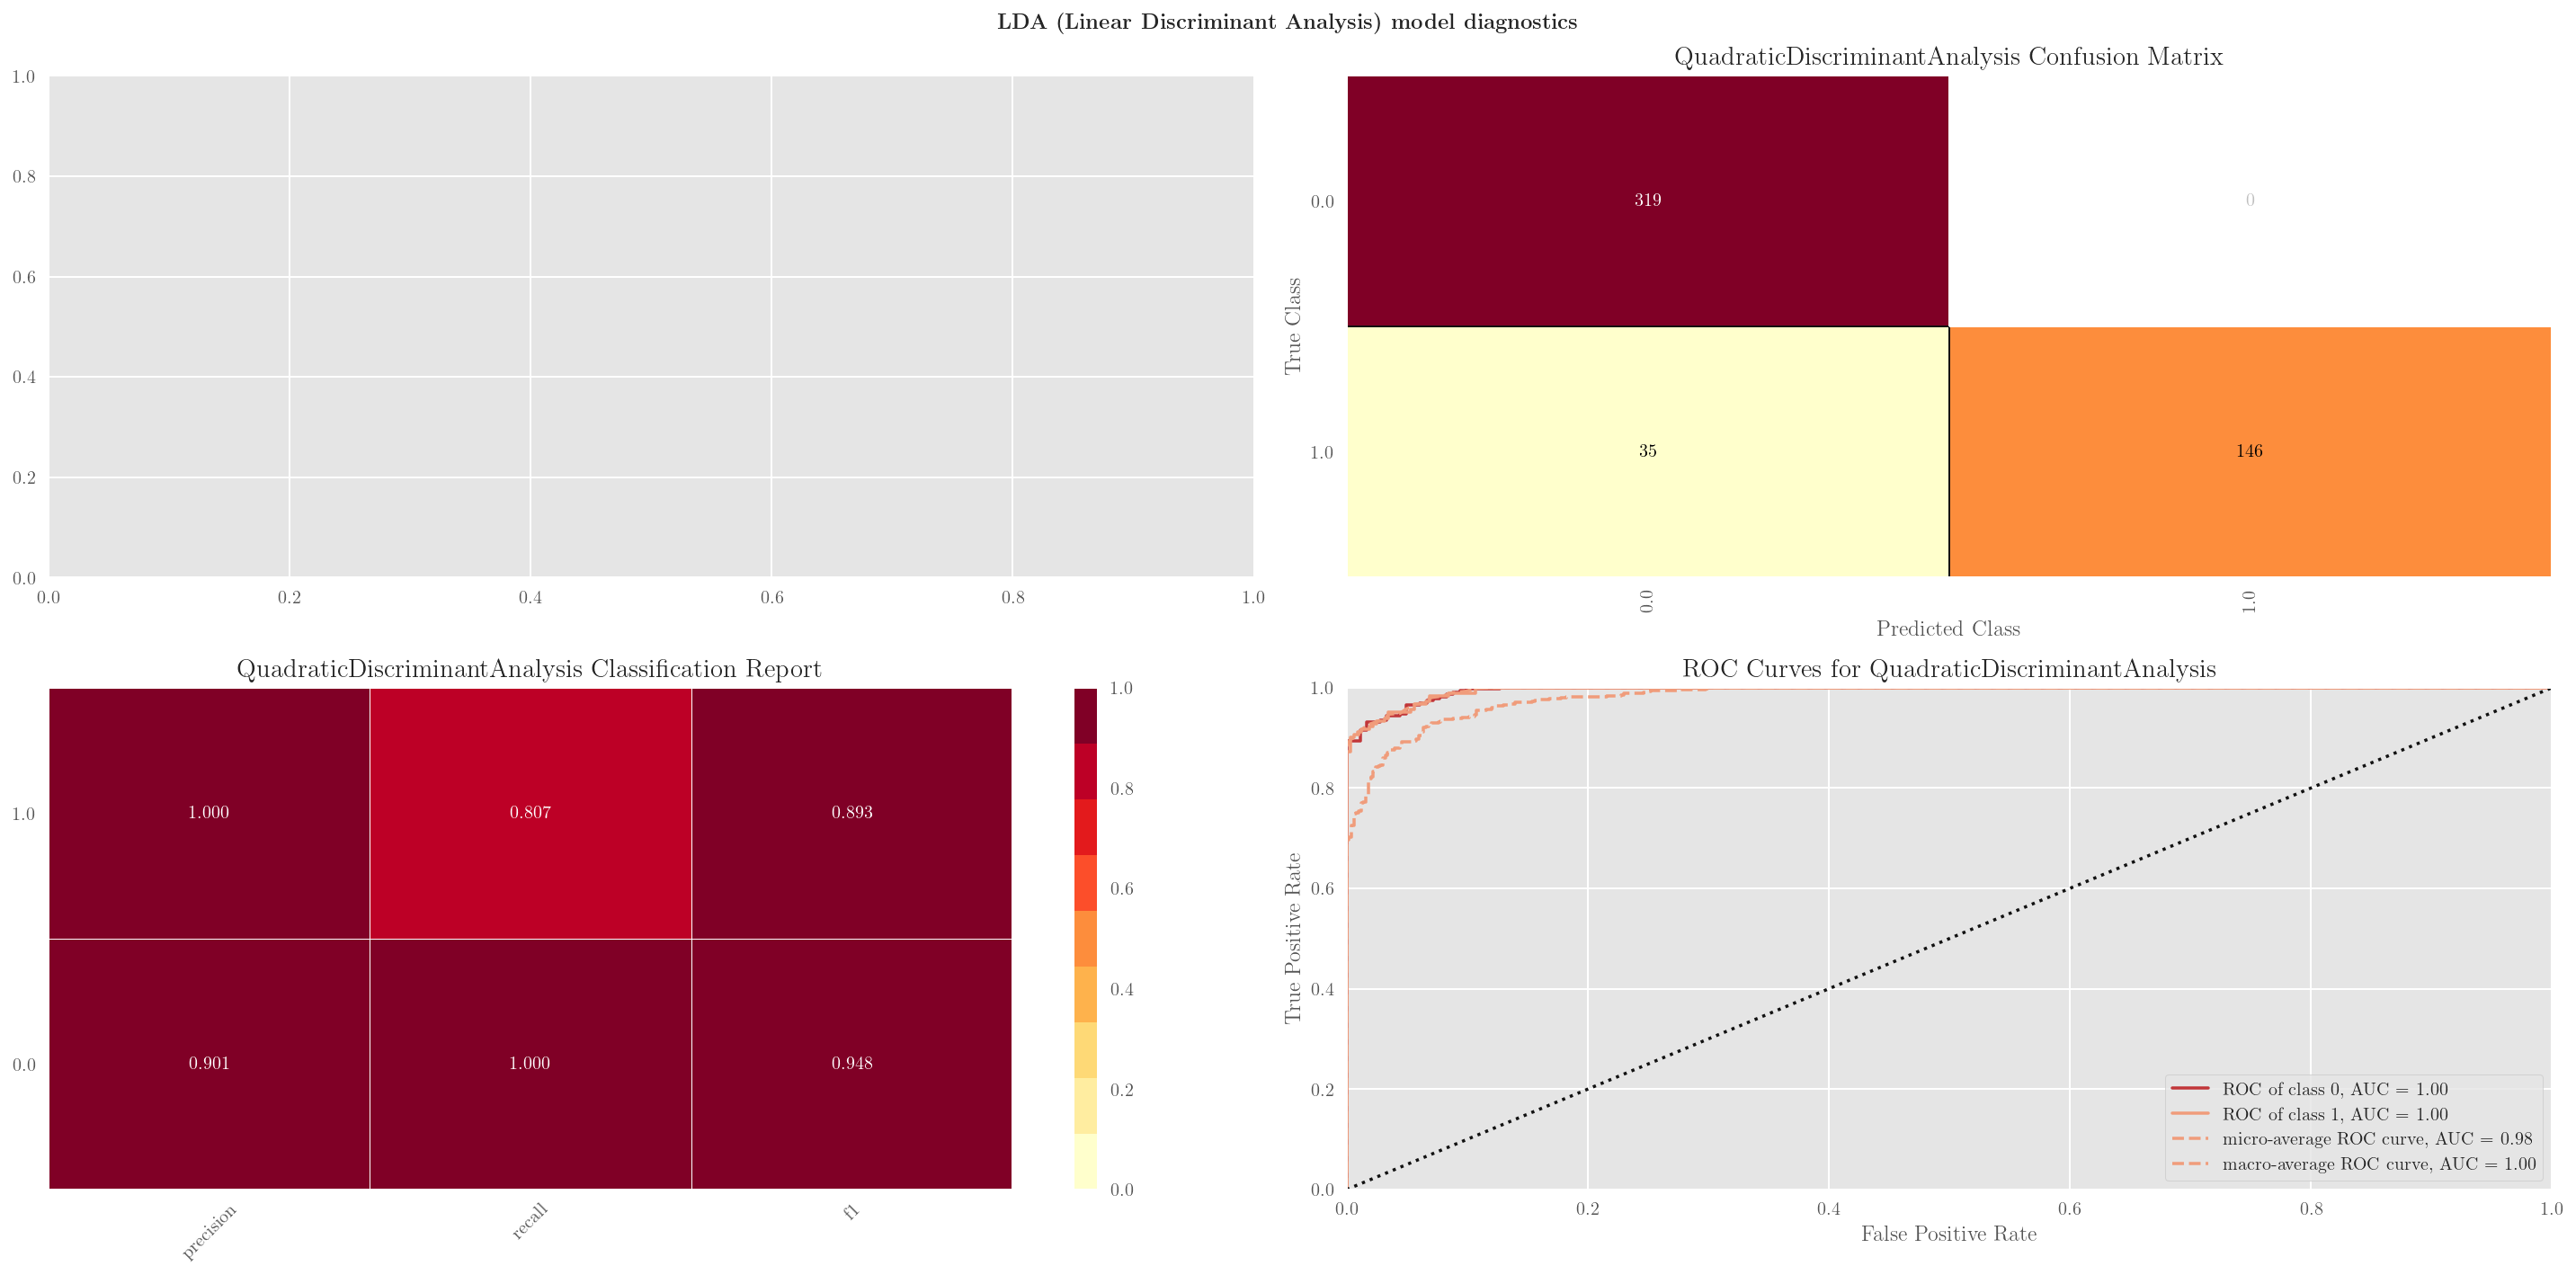

In [22]:

fig, axes = plt.subplots(2, 2)

model = lda
visualgrid = [
   # FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test, )
    viz.finalize()

plt.suptitle(r'\textbf{LDA (Linear Discriminant Analysis) model diagnostics}');
plt.tight_layout();

### Visual model predictions

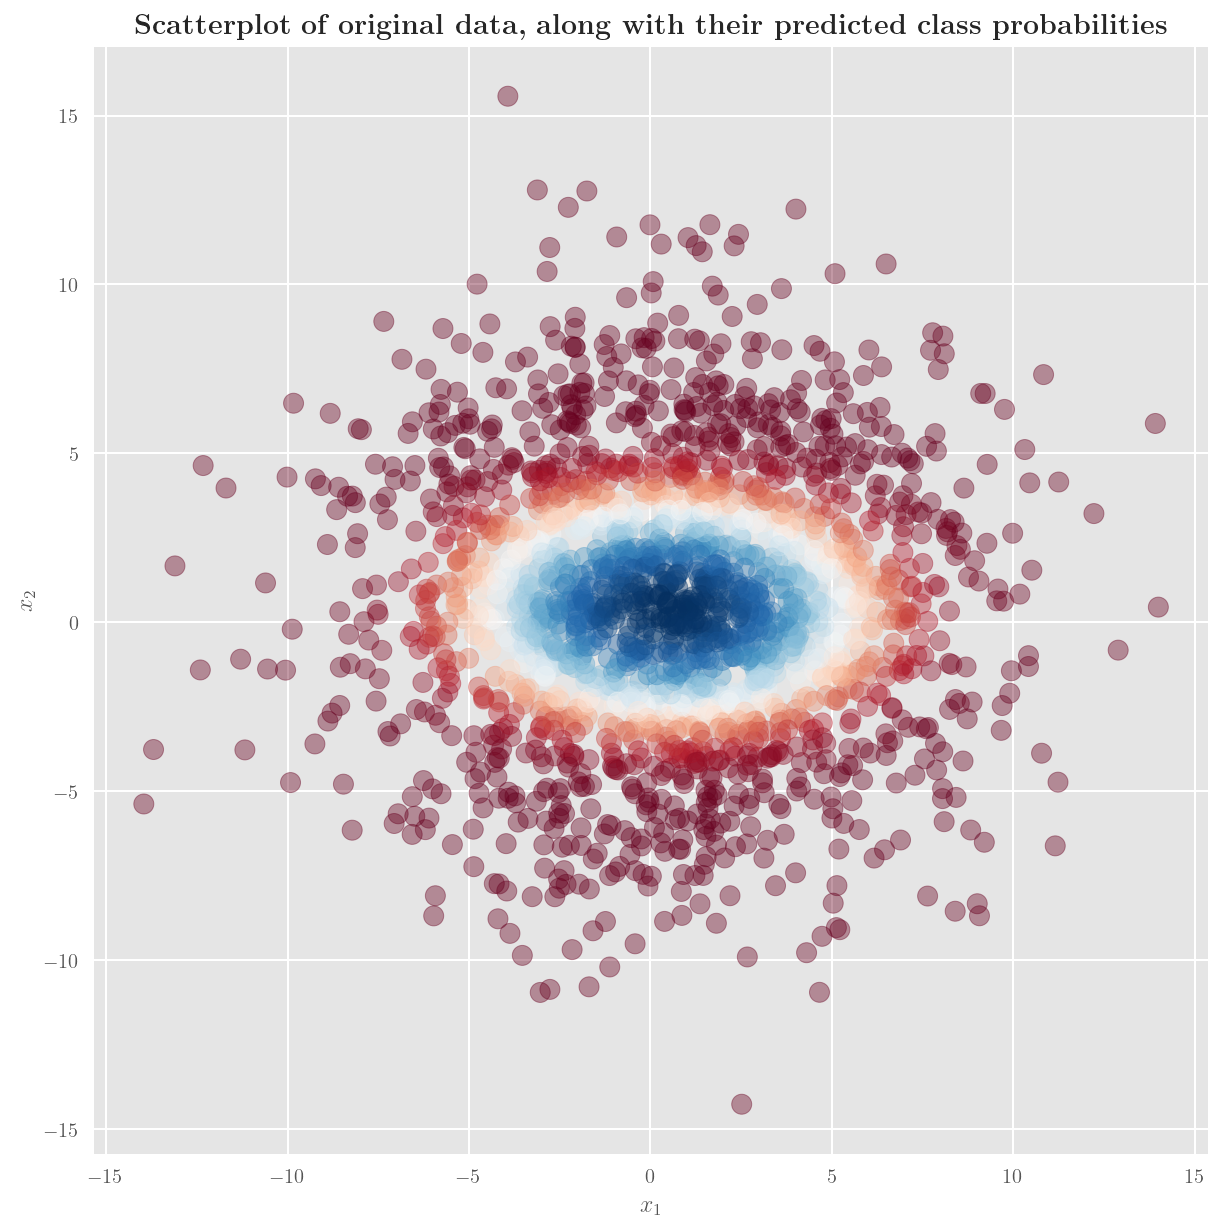

In [23]:
plt.figure(figsize=(10,10))
plt.scatter(X['x1'],   # as the x-axis 
            X['x2'],   # as the y-axis
            s=100,
            alpha=0.4, # size
            c=predictions,
            cmap='RdBu',
            
           )
plt.xlabel (r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r'\textbf{Scatterplot of original data, along with their predicted class probabilities}');


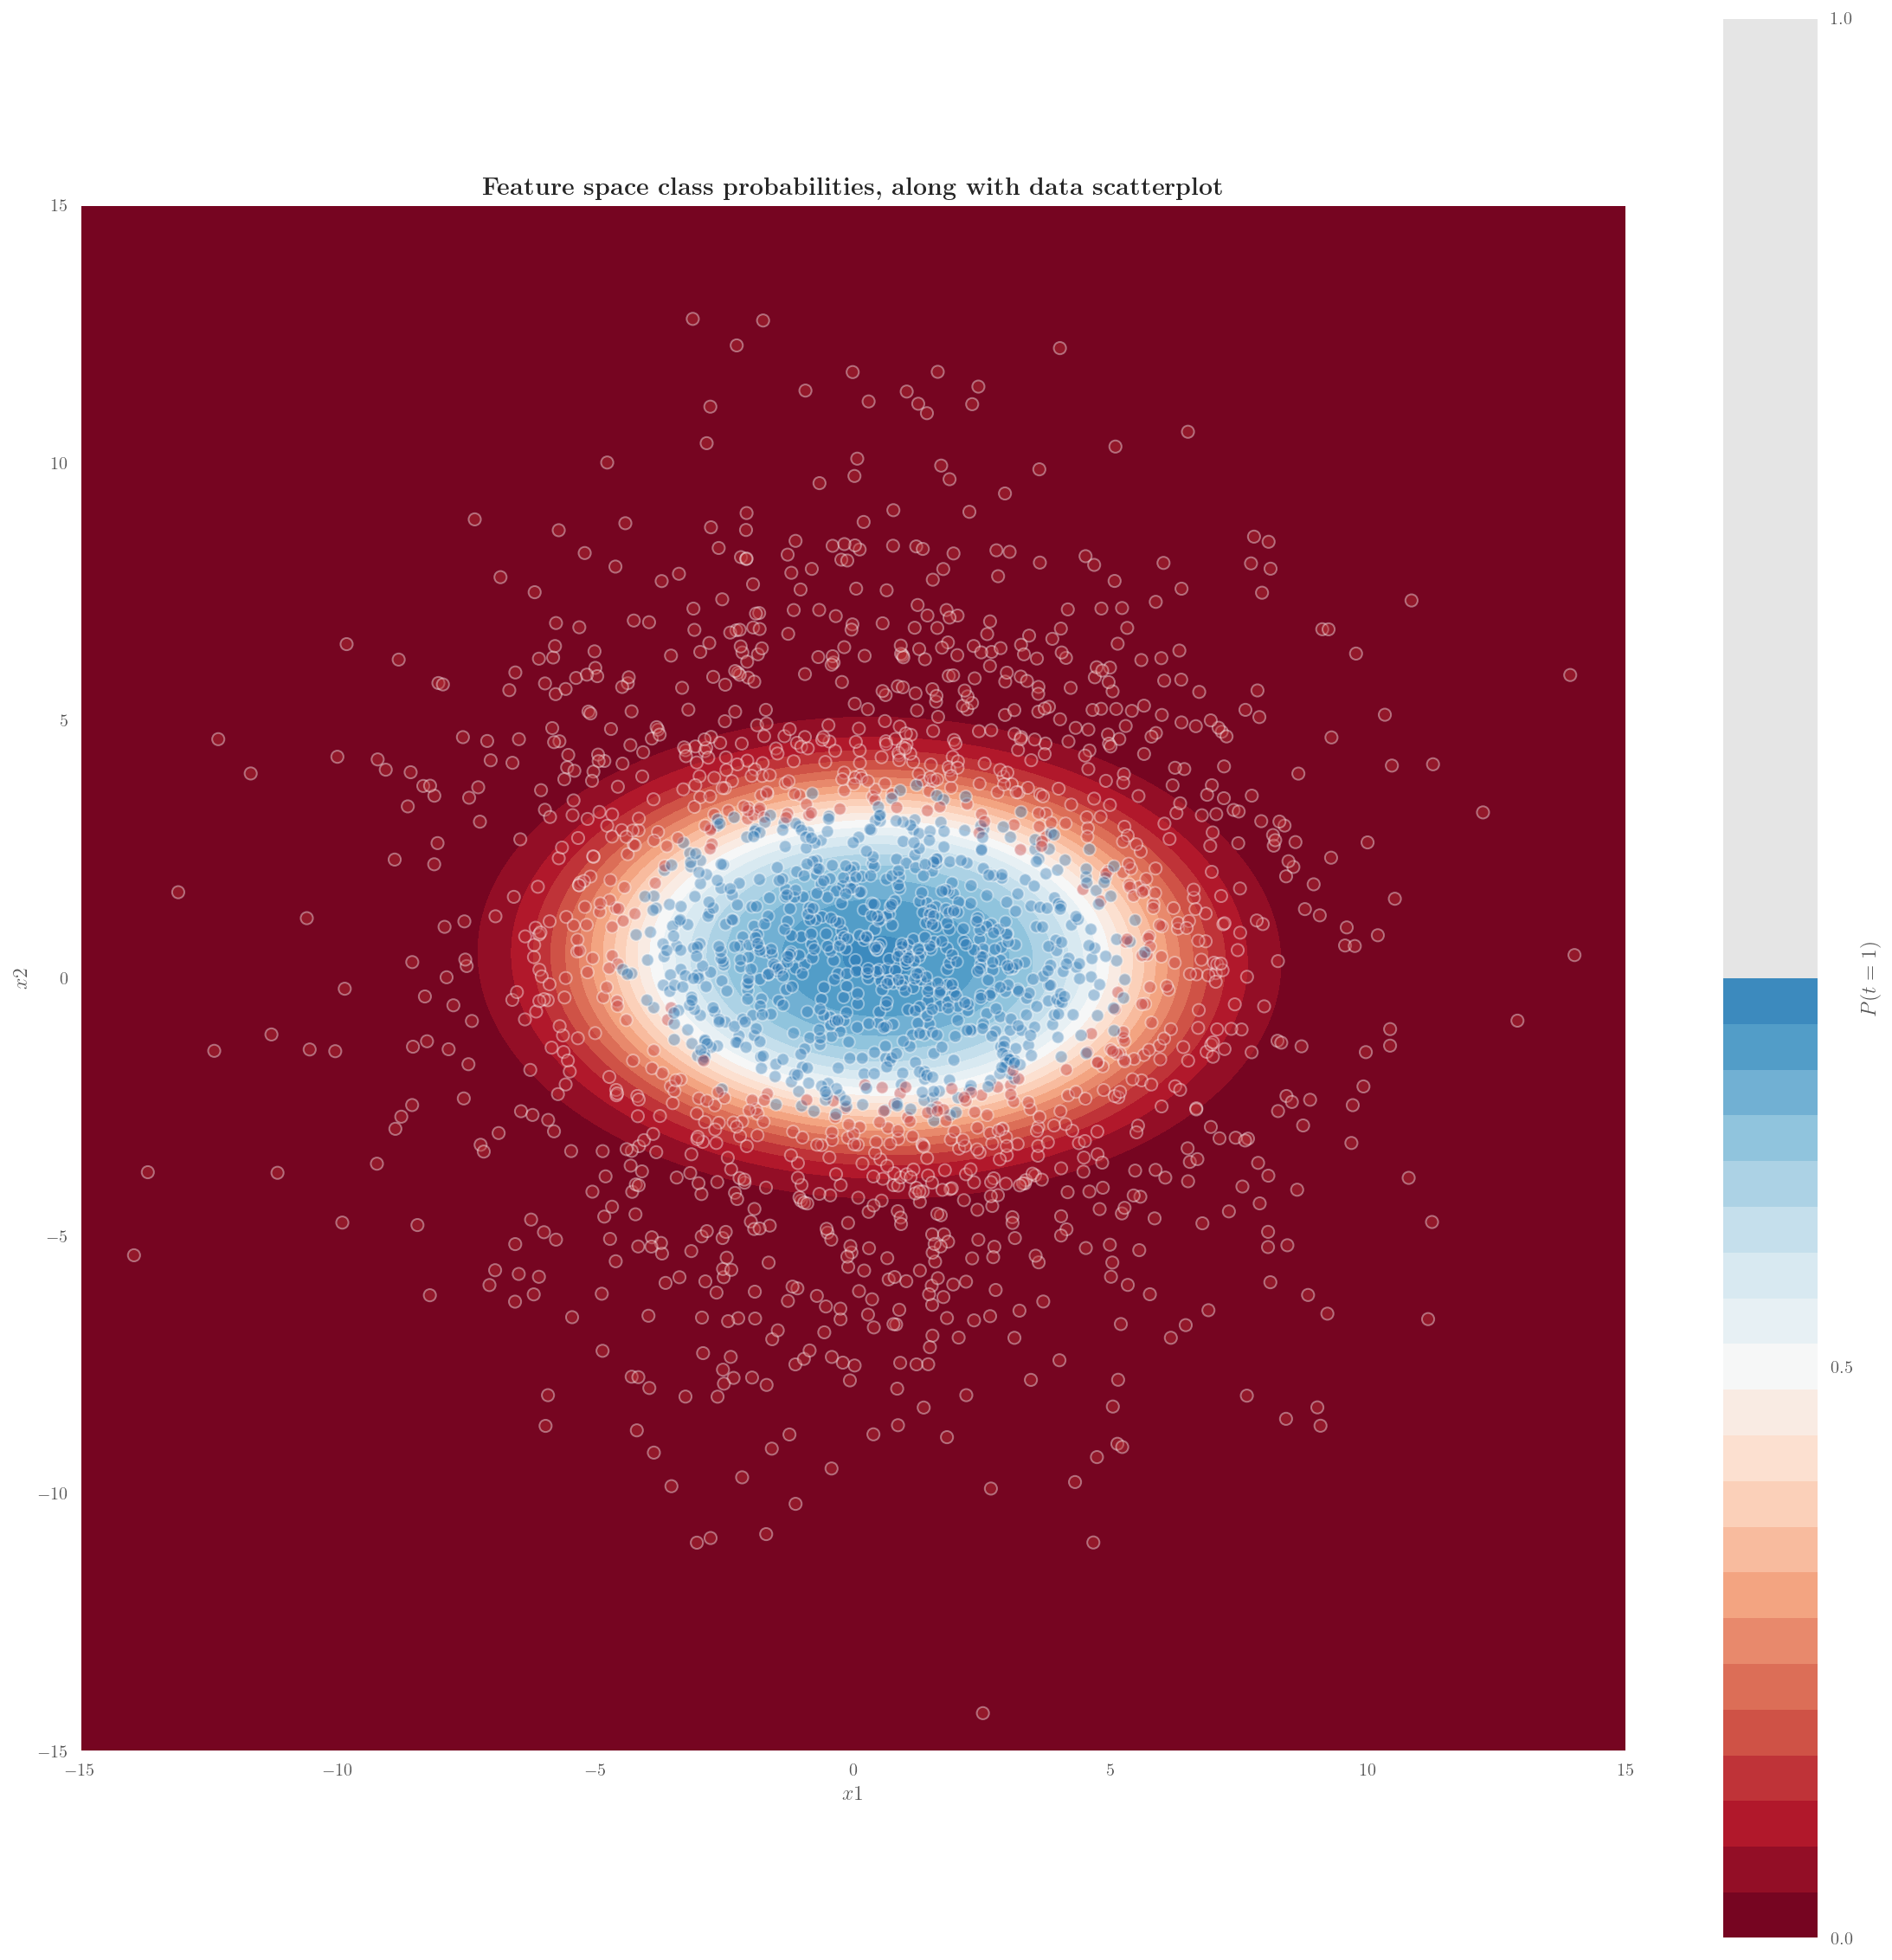

In [24]:

sample_x, sample_y = np.mgrid[-15:15:.01, -15:15:.01]
grid = np.c_[sample_x.ravel(), sample_y.ravel()]

probs = lda.predict_proba(grid)[:, 1].reshape(sample_x.shape)

# Now let us draw the decision-boundary
figure, axes = plt.subplots(figsize=(20,20));
contour = axes.contourf (sample_x, 
                         sample_y, 
                         probs, 
                         25, 
                         cmap="RdBu",
                         vmin=0,
                         vmax=1);
axes_color = figure.colorbar(contour)
axes_color.set_label("$P(t=1)$")
axes_color.set_ticks ([0.0, 0.5, 1.0])


# Draw the scatterplot
axes.scatter(X['x1'], 
             X['x2'], 
             c=y, 
             s=50, 
             cmap="RdBu", 
             vmin=-0.2, 
             vmax=1.2, 
             edgecolor="white", 
             linewidth=1,
             alpha=0.4);

#Labels, etc.
axes.set(aspect="equal", 
         xlim=(-15,15),
         ylim=(-15,15),
         xlabel=r'$x1$',
         ylabel=r'$x2$'
        );

plt.title(r'\textbf{Feature space class probabilities, along with data scatterplot}');



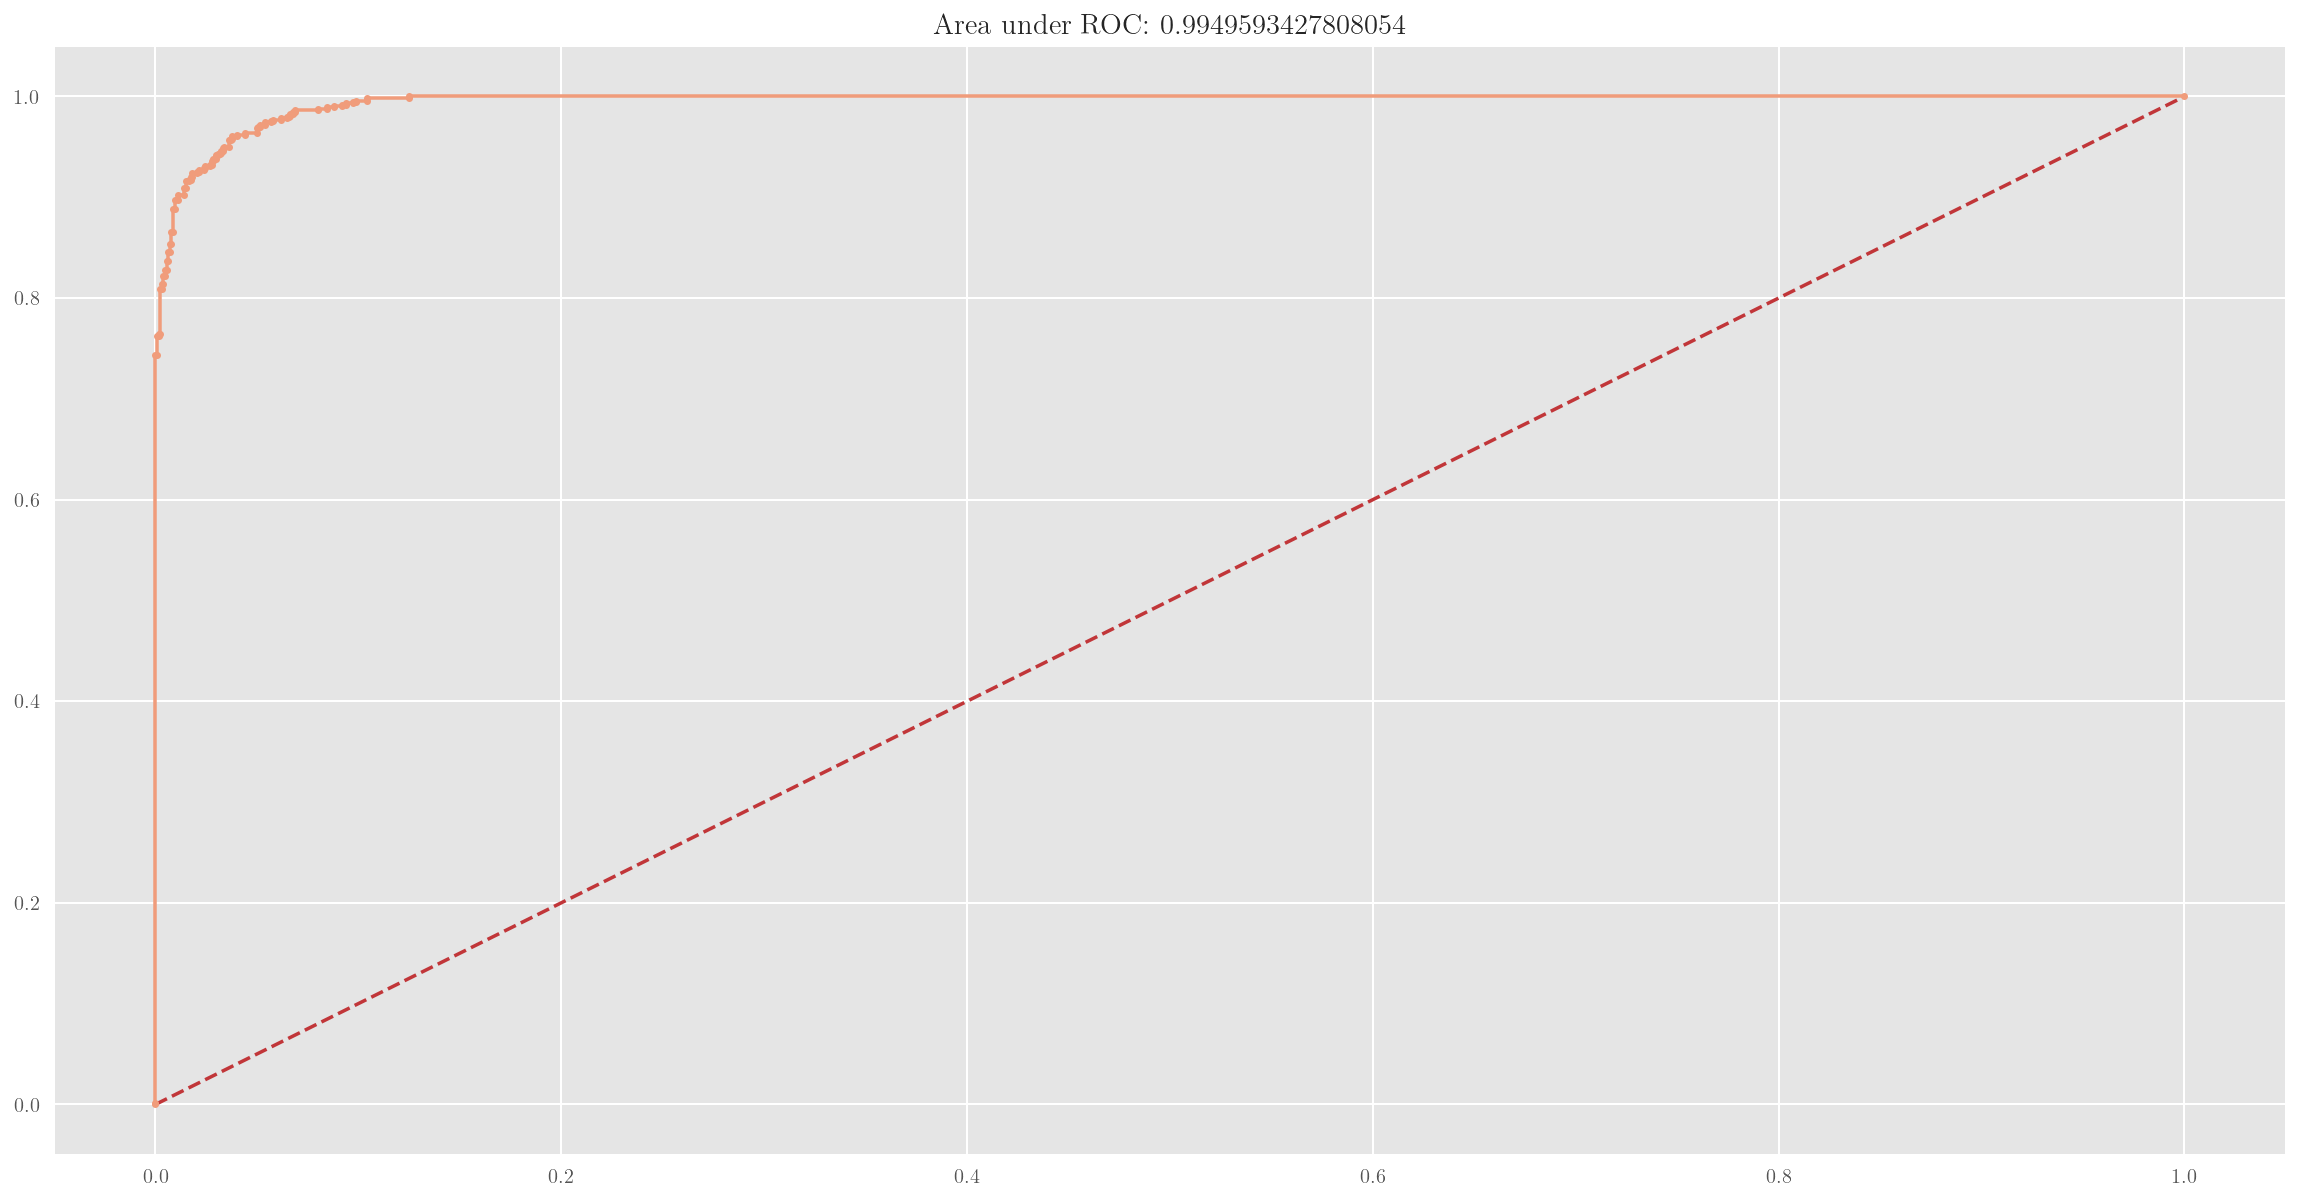

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y, predictions)
auROC = roc_auc_score(y, predictions)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.title("Area under ROC: {}".format(auROC))
plt.show()

## Revisiting with logistic regression

We have learned that we can sometimes linearize a dataset through judicious tansformations. In this particular case, let us try a polynomial expansion of the features.

In [26]:
model = make_pipeline(PolynomialFeatures(4), LogisticRegression())
model.fit(X_train, y_train)
yhat = model.predict(X_test)
predictions = model.predict_proba(X_test)[:, 1].reshape(y_test.shape)

### Model diagnostics

In [27]:
confusion_matrix_ = confusion_matrix(y_test, y_pred)
print(confusion_matrix_)

[[319   0]
 [ 35 146]]


In [28]:

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       319
         1.0       1.00      0.81      0.89       181

    accuracy                           0.93       500
   macro avg       0.95      0.90      0.92       500
weighted avg       0.94      0.93      0.93       500



### Class Probabilities

In the `sklearn` library, the class probabilities can be seen using the `.predict_proba(X)` method. It returns an array whose rows are the predictions for each row of `X`, and the columns are the class probabilities. In the clase of binary classifier, it is enough to retrieve the proabilities of one of the classes, since the other will be the complement of it.

In [29]:
predictions = model.predict_proba(X)[:, 1].reshape(y.shape)
yhat=model.predict(X)

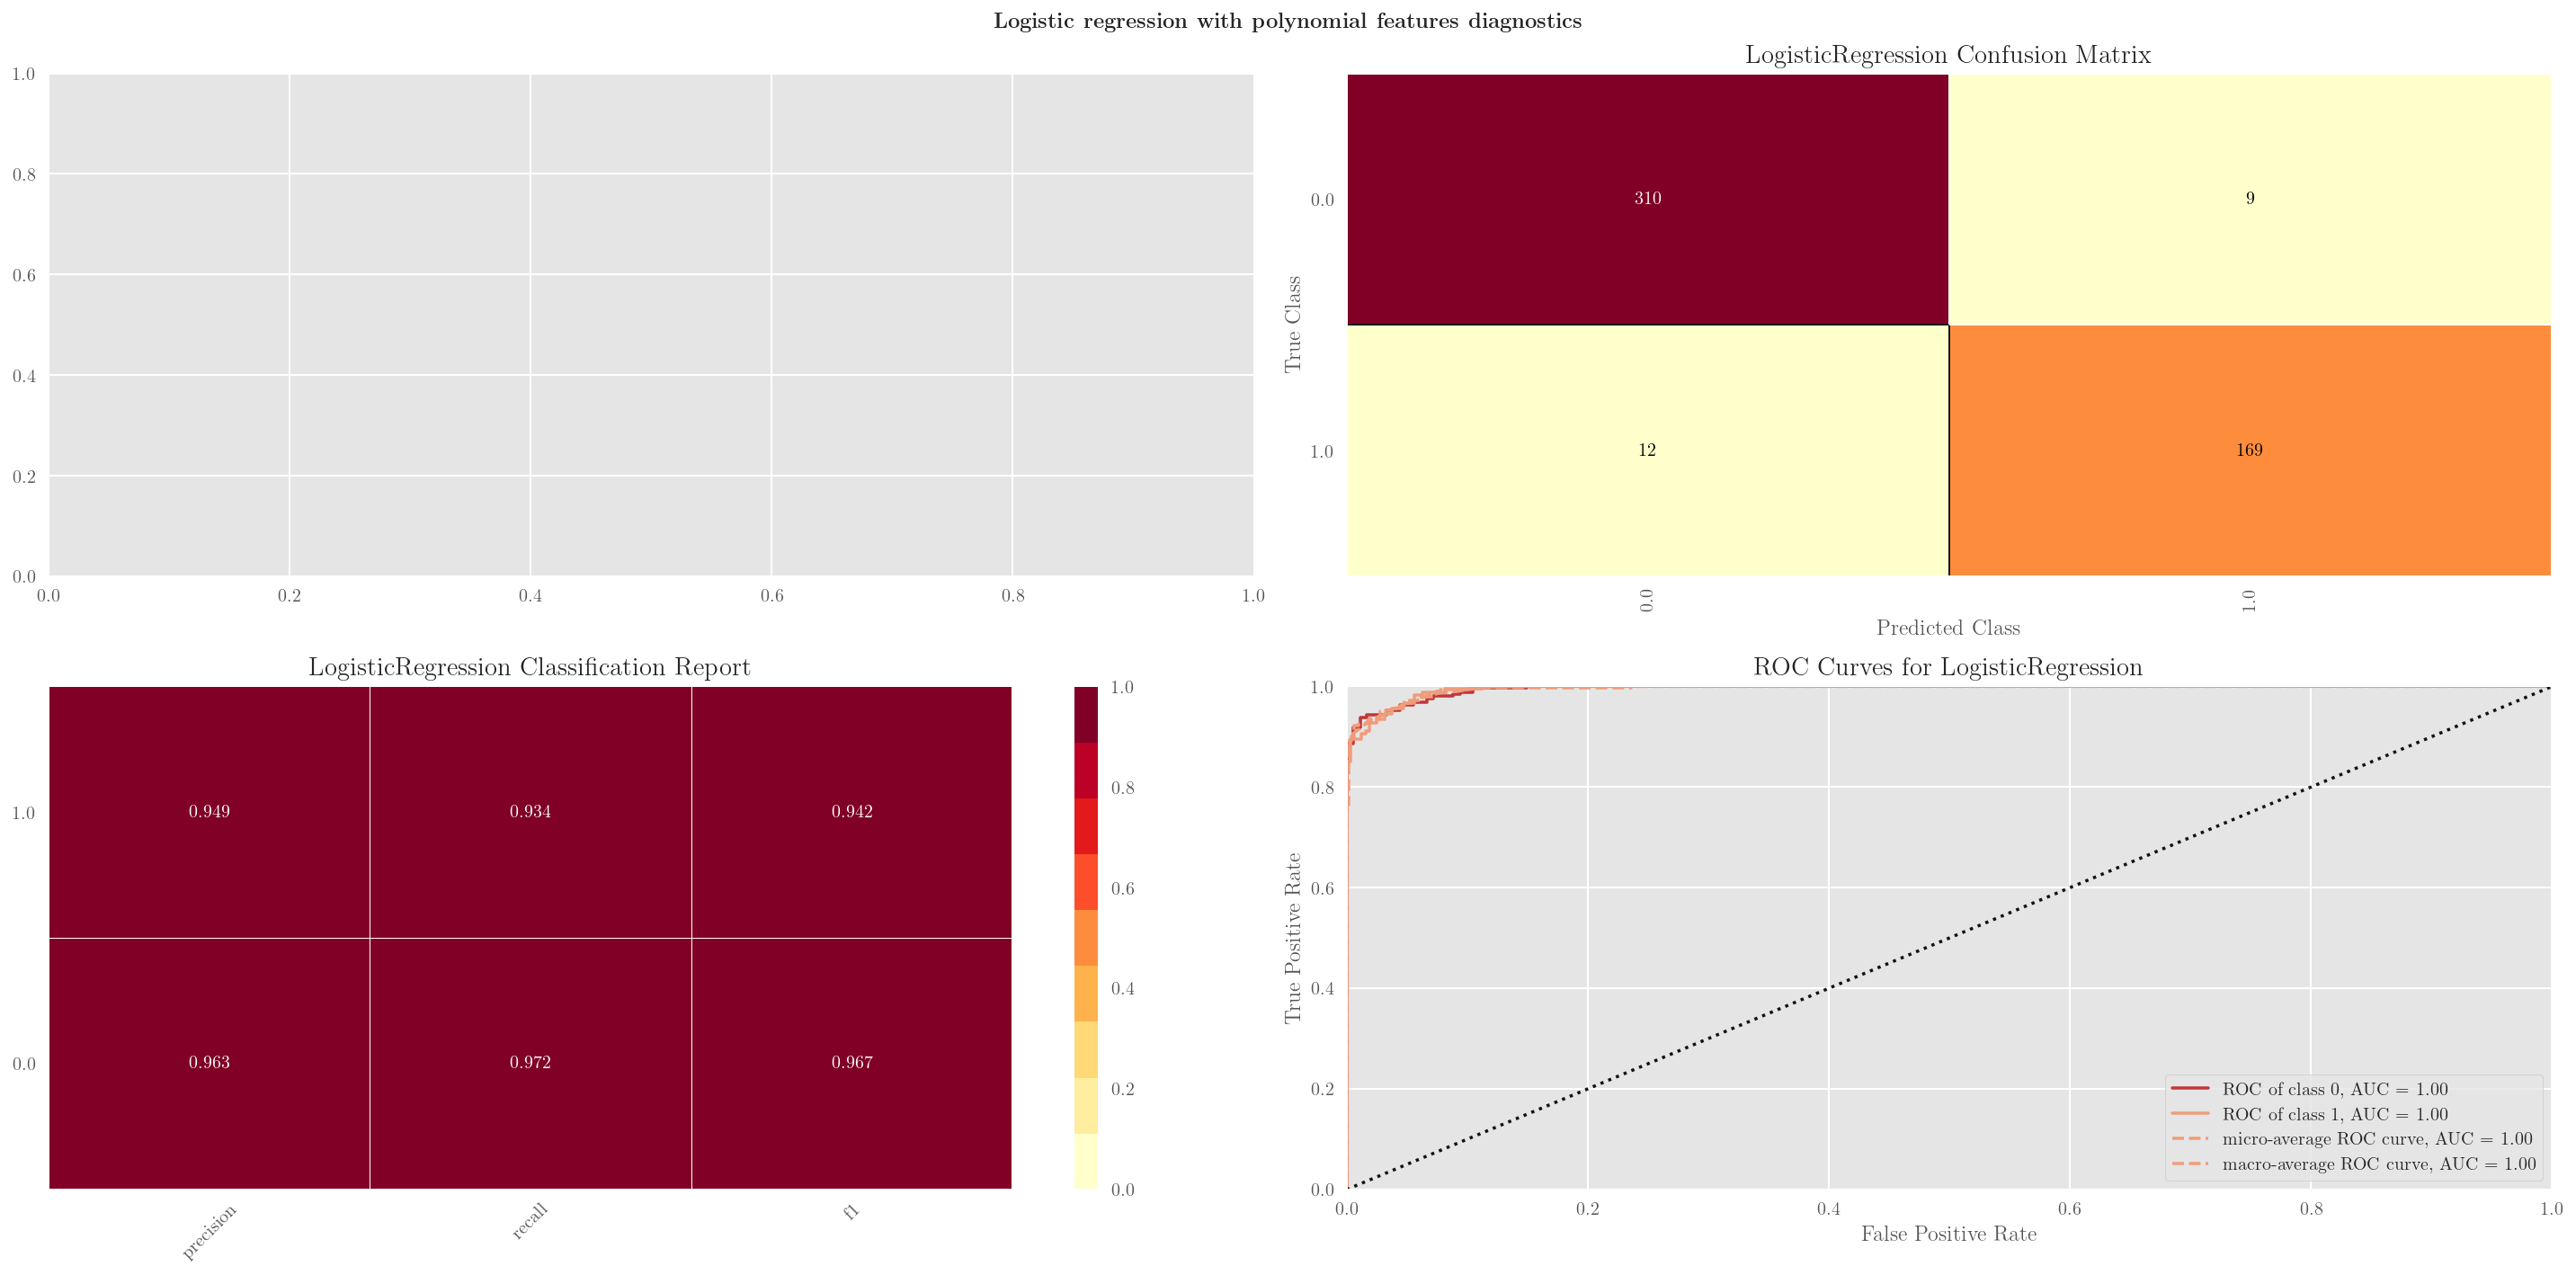

In [30]:

fig, axes = plt.subplots(2, 2)

visualgrid = [
   # FeatureImportances(model, ax=axes[0][0]),
    ConfusionMatrix(model, ax=axes[0][1]),
    ClassificationReport(model, ax=axes[1][0]),
    ROCAUC(model, classes = ['0', '1'], ax=axes[1][1]),
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test, )
    viz.finalize()

plt.suptitle(r'\textbf{Logistic regression with polynomial features diagnostics}');
plt.tight_layout();

### Visual model predictions

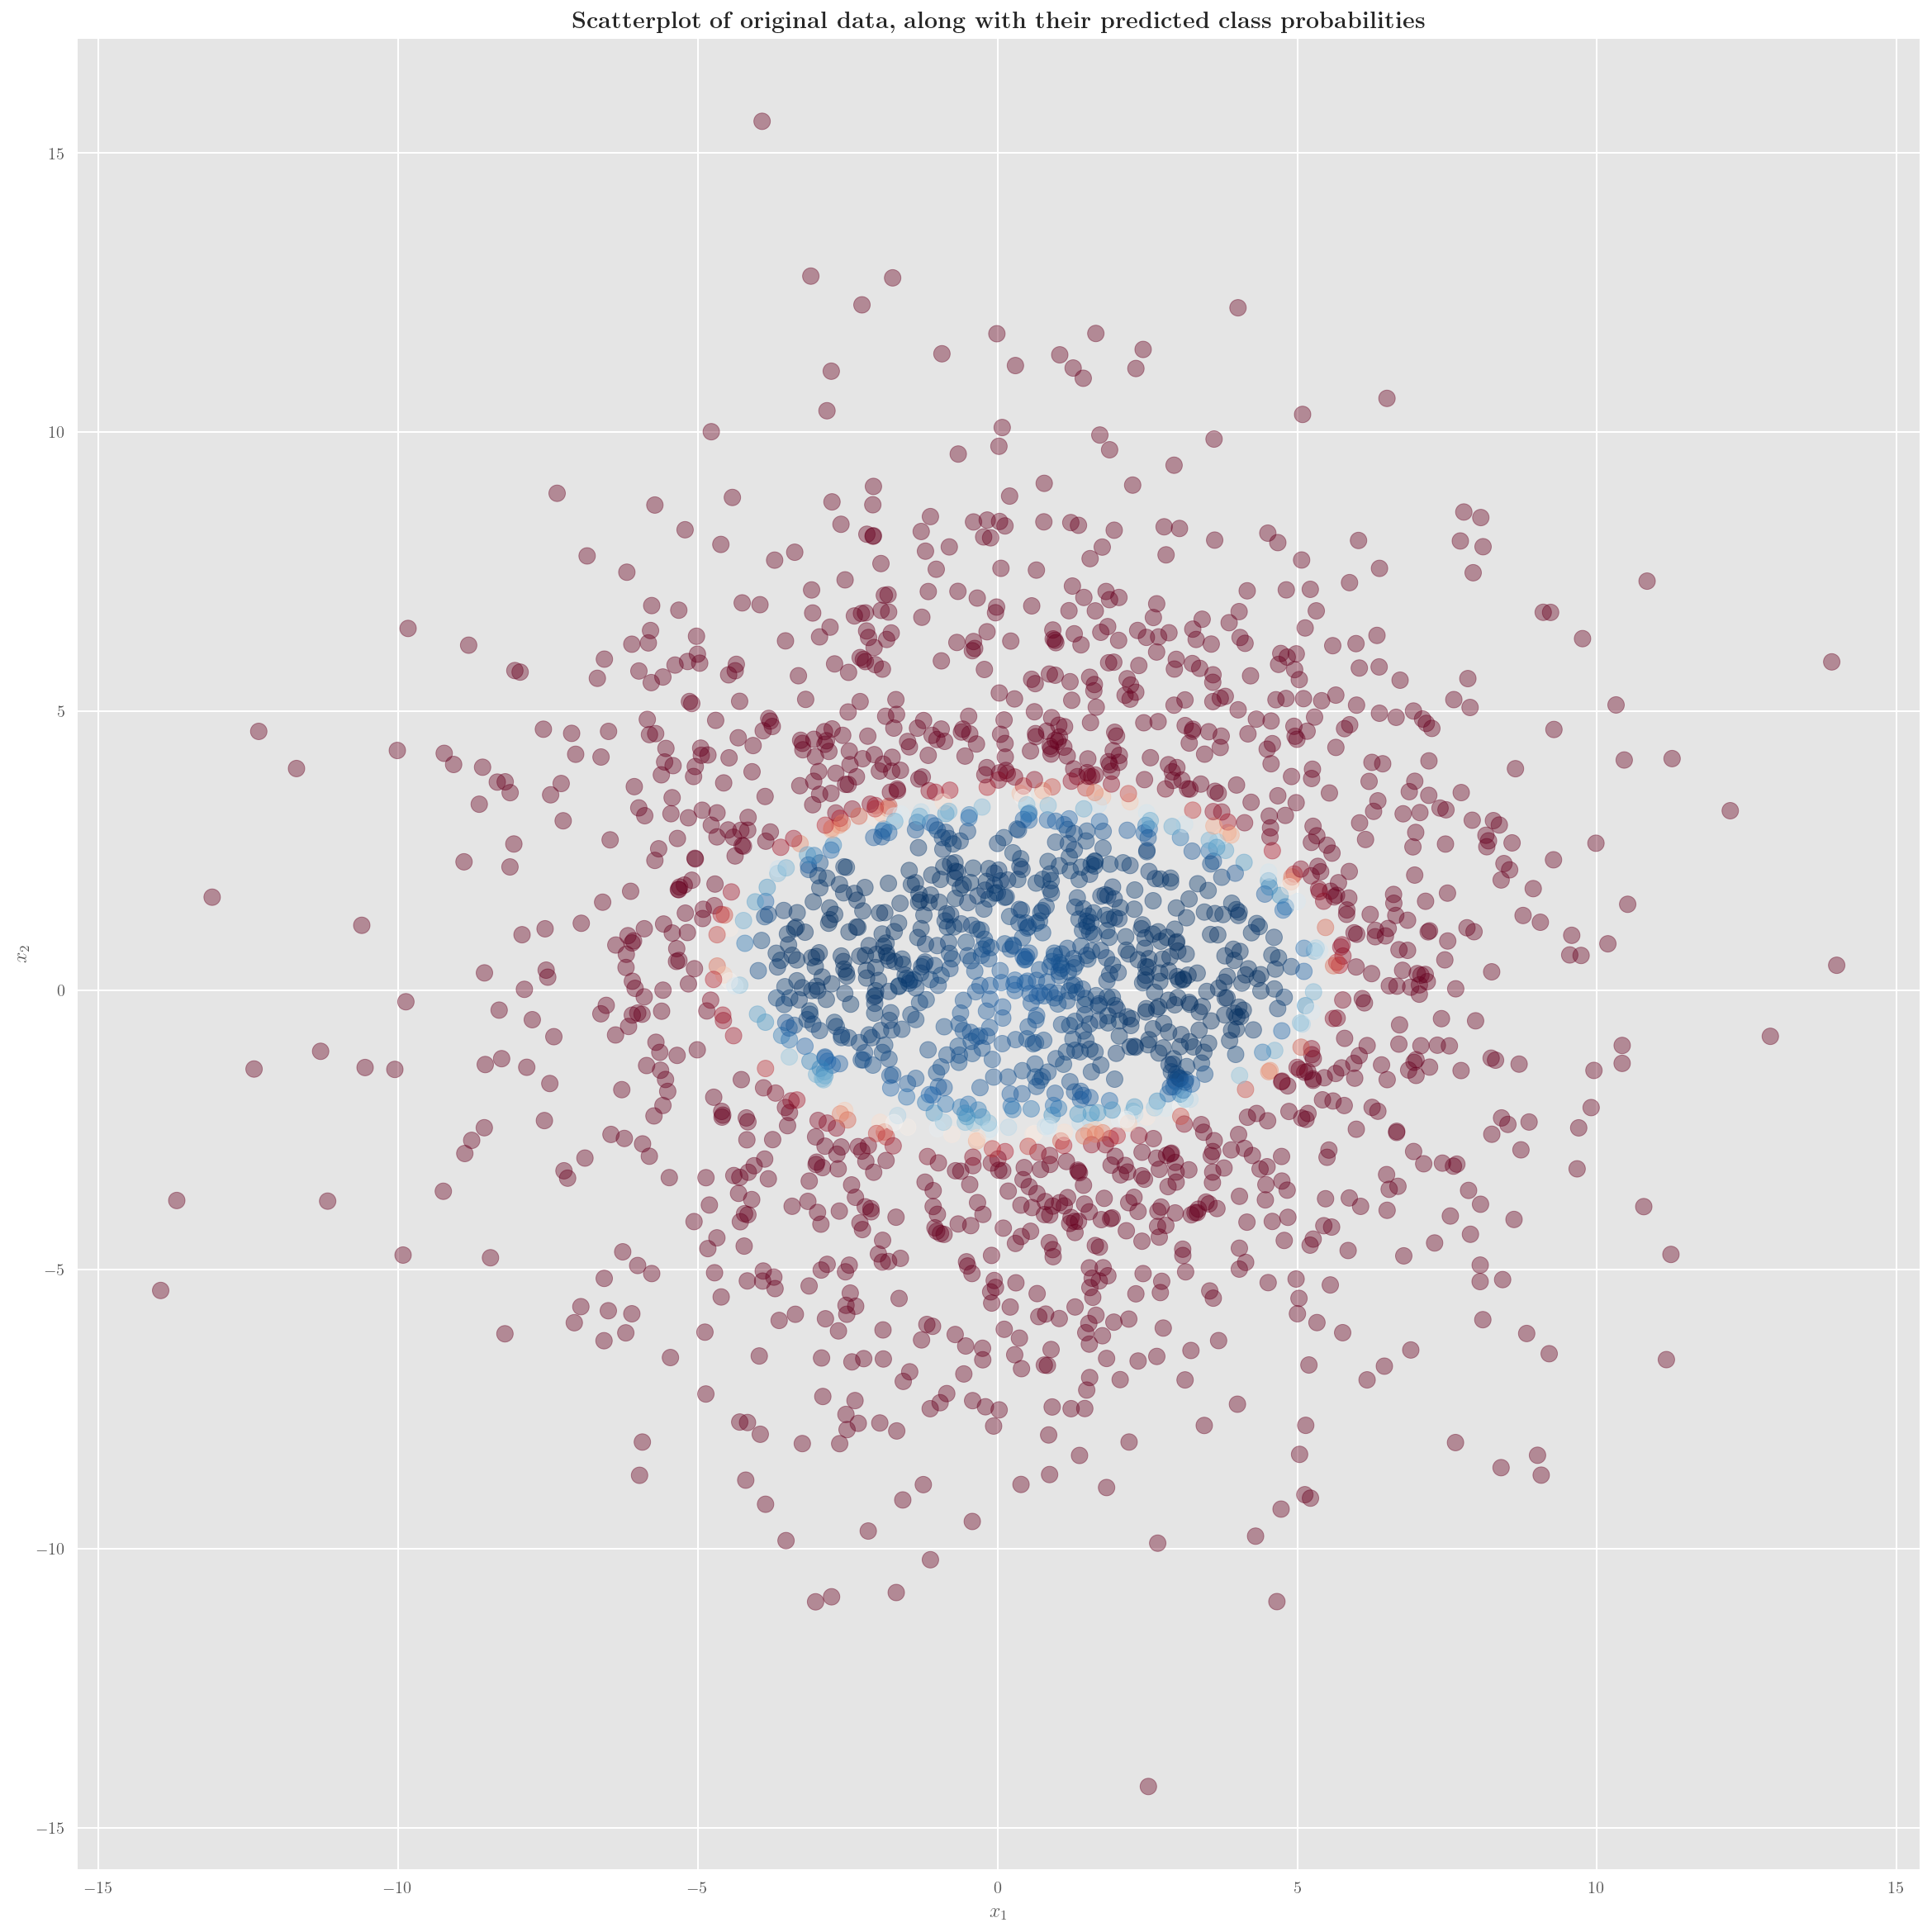

In [31]:
plt.figure(figsize=(20,20))
plt.scatter(X['x1'],   # as the x-axis 
            X['x2'],   # as the y-axis
            s=100,
            alpha=0.4, # size
            c=predictions,
            cmap='RdBu',
            
           )
plt.xlabel (r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title(r'\textbf{Scatterplot of original data, along with their predicted class probabilities}');


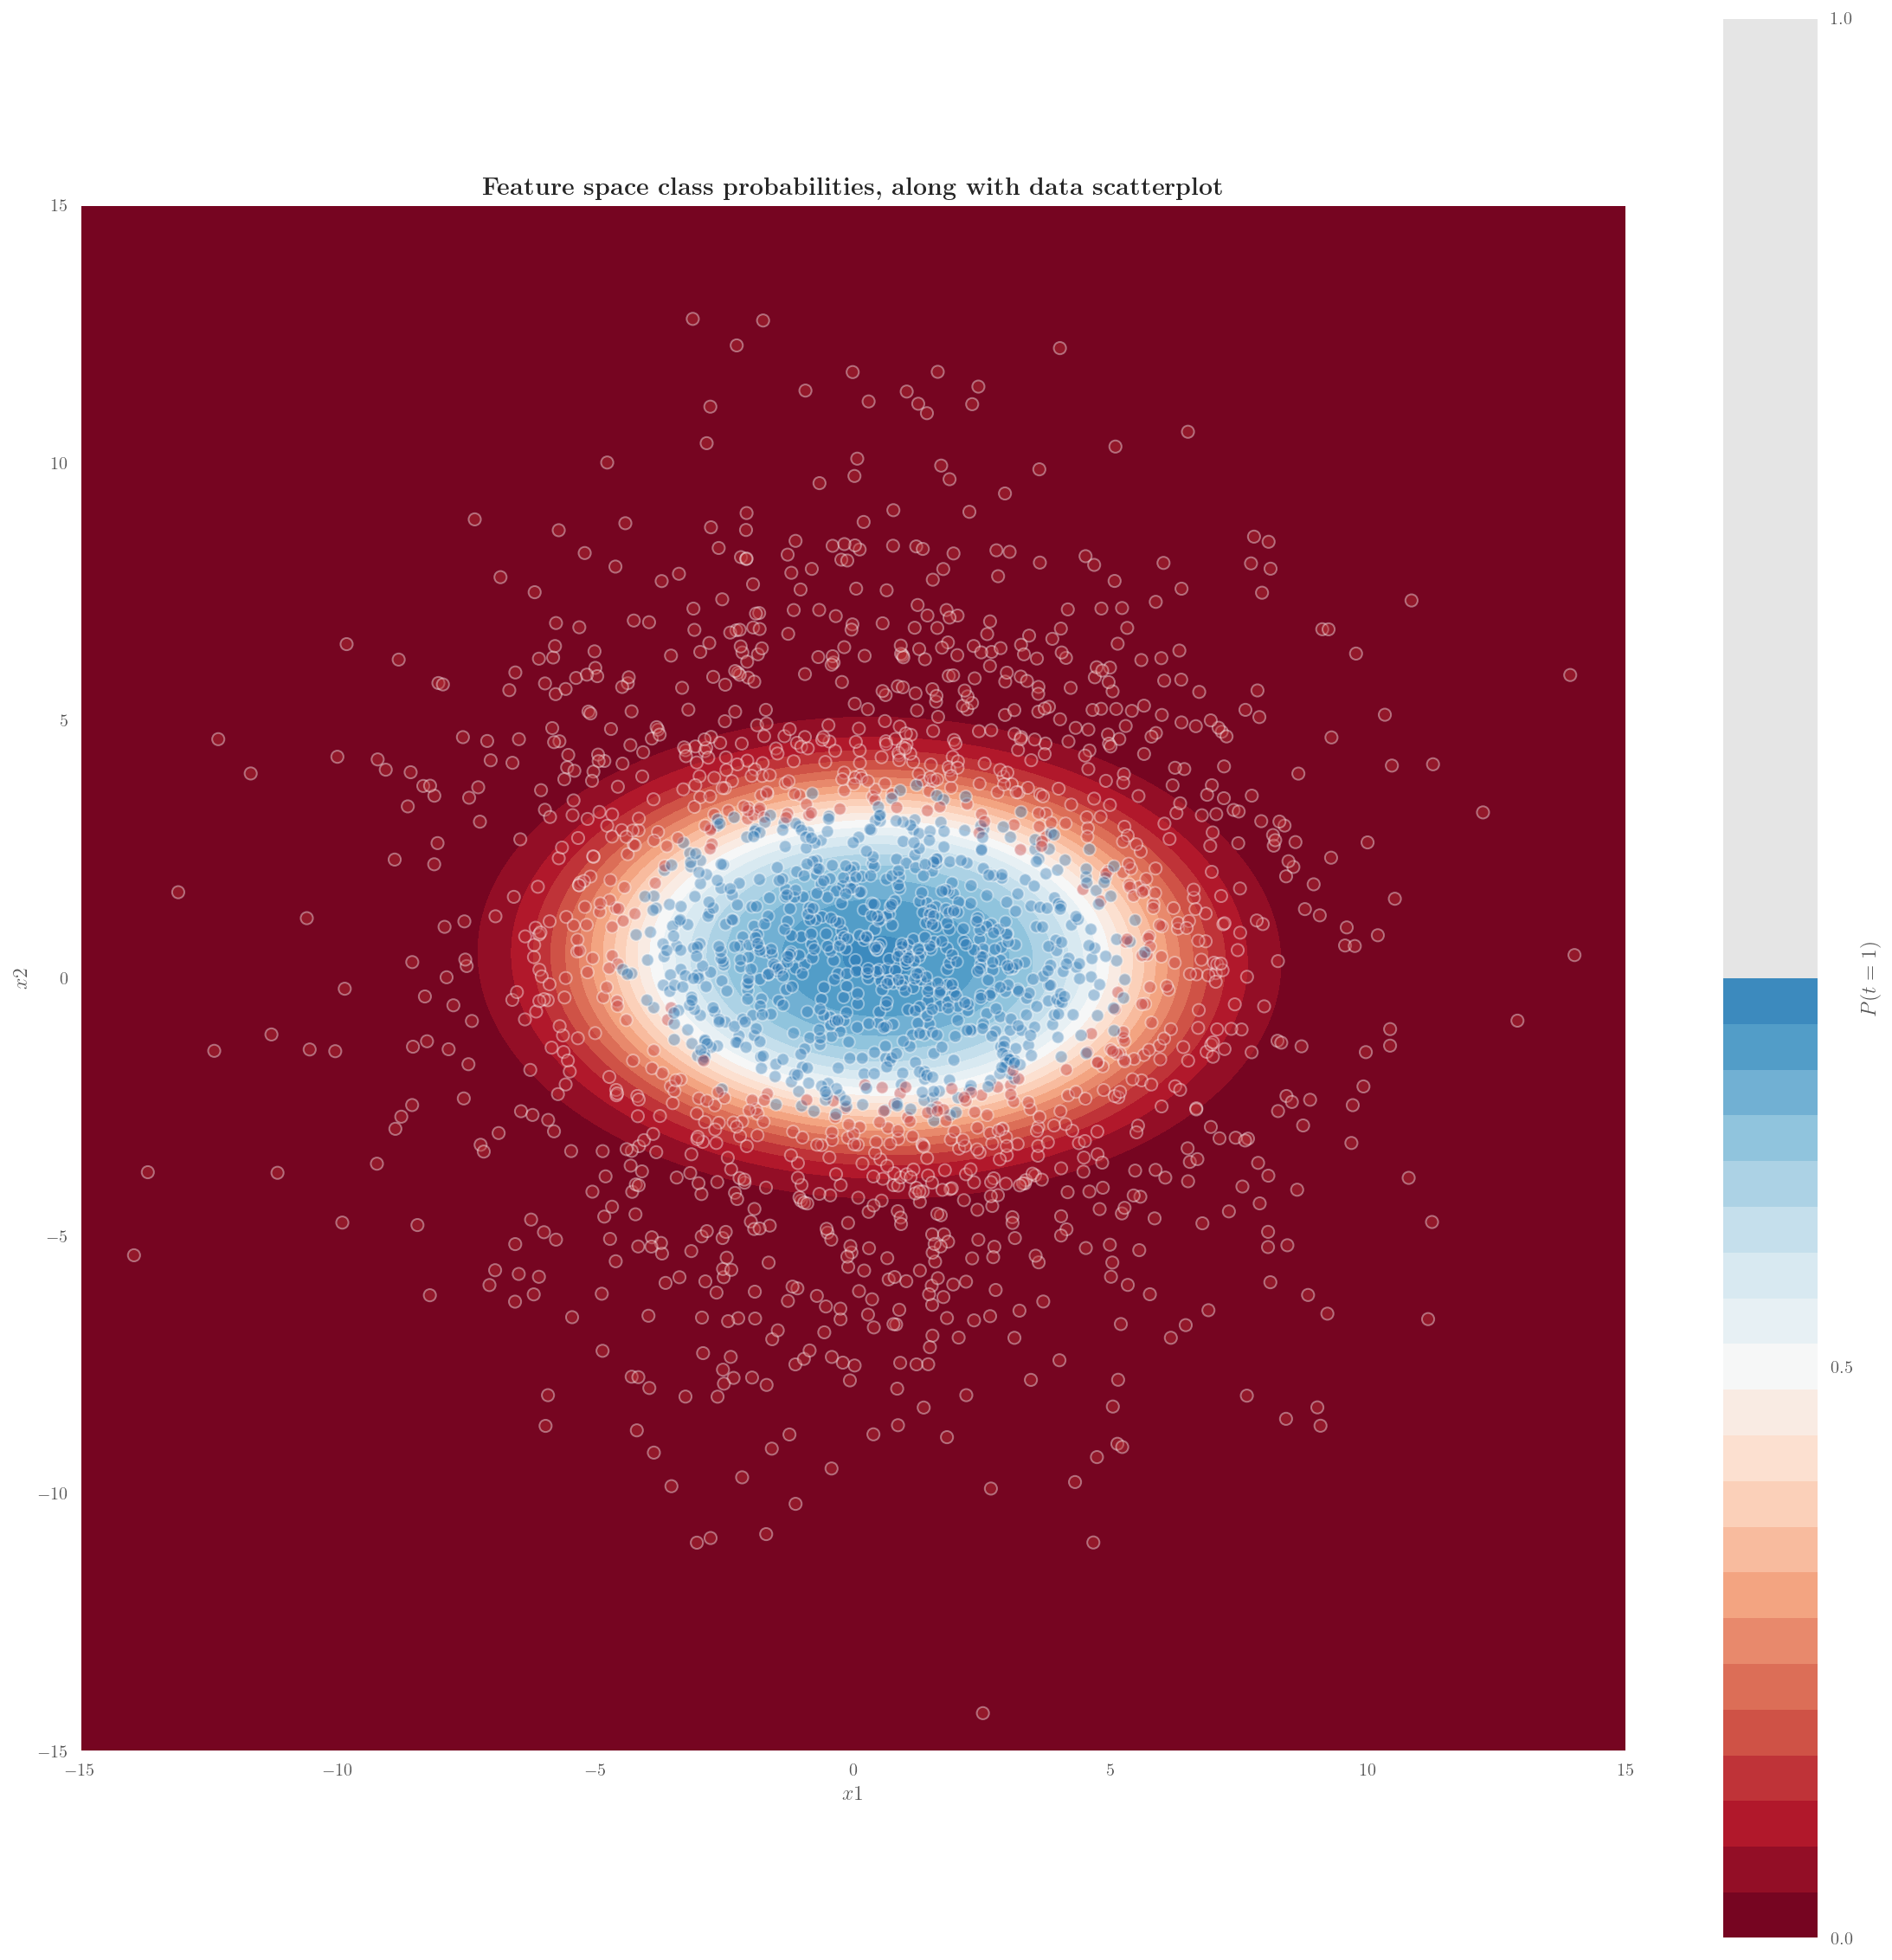

In [32]:

sample_x, sample_y = np.mgrid[-15:15:.01, -15:15:.01]
grid = np.c_[sample_x.ravel(), sample_y.ravel()]

probs = lda.predict_proba(grid)[:, 1].reshape(sample_x.shape)

# Now let us draw the decision-boundary
figure, axes = plt.subplots(figsize=(20,20));
contour = axes.contourf (sample_x, 
                         sample_y, 
                         probs, 
                         25, 
                         cmap="RdBu",
                         vmin=0,
                         vmax=1);
axes_color = figure.colorbar(contour)
axes_color.set_label("$P(t=1)$")
axes_color.set_ticks ([0.0, 0.5, 1.0])


# Draw the scatterplot
axes.scatter(X['x1'], 
             X['x2'], 
             c=y, 
             s=50, 
             cmap="RdBu", 
             vmin=-0.2, 
             vmax=1.2, 
             edgecolor="white", 
             linewidth=1,
             alpha=0.4);

#Labels, etc.
axes.set(aspect="equal", 
         xlim=(-15,15),
         ylim=(-15,15),
         xlabel=r'$x1$',
         ylabel=r'$x2$'
        );

plt.title(r'\textbf{Feature space class probabilities, along with data scatterplot}');

